<a href="https://colab.research.google.com/github/anna-dang/dsc-phase-4-project/blob/main/project_4_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision: X-Ray Classification using Convolutional Neural Networks

Anna D’Angela

December 15th, 2020

Project for Flatiron School, Online Data Science Program

Phase 4 Project - Neural Networks

[Return to GitHub Repo](https://github.com/anna-dang/dsc-phase-4-project)



**Business case**

Even for a trained radiologist, it is challenging to examine chest X-rays for markers of pneumonia. There is a need to improve the diagnostic accuracy. A medical imaging company is looking to increase efficiency for its technicians by building a classifier to aid them in detecting pneumonia from chest X-ray images.


**Objective** 

Build a model that can classify whether a given patient has pneumonia, given a chest x-ray image.

Sources: [original image source](https://data.mendeley.com/datasets/rscbjbr9sj/2), [data download source/Kaggle competition](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

### Connect to Google Drive / Download Data

Placed above the below cells for instances of Colab inactivity timeout. Run all cells below this section without having to reload data.

In [1]:
# Mount the connection to Google Drive
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [75]:
# Check current directory (the 'local' directory where Colab operates)
import os
os.getcwd()

'/content'

In [3]:
# Define 'local' path as the directory of the virtual machine (where Colab runs)
local_path = '/content'

# Path where data .zip file is stored on Google Drive
zip_path = '/gdrive/MyDrive/kaggle/chest-xray-pneumonia.zip'

In [4]:
# Copy .zip file into virtual machine
!cp '{zip_path}' .

In [5]:
# Unzip in virtual machine/pwd
!unzip -q 'chest-xray-pneumonia.zip'

  error:  invalid compressed data to inflate chest_xray/chest_xray/train/NORMAL/IM-0505-0001-0001.jpeg
file #6812:  bad zipfile offset (local header sig):  268650984
  error:  invalid compressed data to inflate chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0587-0001-0001.jpeg
  error:  invalid compressed data to inflate chest_xray/train/NORMAL/NORMAL2-IM-0885-0001.jpeg
file #13302:  bad zipfile offset (local header sig):  1879739618


In [6]:
!pip install lime

     |████████████████████████████████| 276kB 11.9MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=3cadde611debee7b933da00f9037299c113018833b597407477581ca3396fce1
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [7]:
!pip install visualkeras

### Import libraries

In [64]:
import random, cv2, visualkeras 

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from collections import defaultdict
from lime import lime_image
from skimage.segmentation import mark_boundaries

from tensorflow.keras import callbacks, models, layers, optimizers, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

seed = 3
np.random.seed(seed)

### Define functions

In [87]:
def get_num_images(file_path, form='total'):
    """ Follows a filepath for this dataset and counts the images per class of NORMAL or PNEUMONIA X-rays.
        Option to return the 'total' elements per folder or a 'tuple' of the count for each type,
        or the 'normed' count (percentage per class of total).

        Output format: (NORMAL, PNEUMONIA) """    

    # Calculate quantities
    normal = len(os.listdir(file_path + '/NORMAL'))
    pneum = len(os.listdir(file_path + '/PNEUMONIA'))
    tot = normal + pneum

    # Format return type
    if form == 'total':
        return tot
    if form == 'normed':
        return tuple(round(i, 3) for i in ((normal/tot), (pneum/tot)))
    if form == 'tuple':
        return (normal, pneum) 



def plot_raw_images(norm_imgs, pneu_imgs, samples):
    """ Displays selected number of raw images direct from training file for each class."""

    # Randomly select images from both classes to inspect
    pneu_imgs = np.random.choice(os.listdir(train_path + '/PNEUMONIA/'), samples, replace = False)
    norm_imgs = np.random.choice(os.listdir(train_path + '/NORMAL/'), samples, replace = False)
  
    # Plot images
    fig, axes = plt.subplots(nrows=2, ncols=samples, figsize=(25, 30))
    for i, img in enumerate(norm_imgs):
        axes[0, i].imshow(cv2.imread(train_path + '/NORMAL/' + img))
        axes[0, i].set_title(f"Normal Lungs")
        axes[0, i].axis("off")
    for i, img in enumerate(pneu_imgs):   
        axes[1, i].imshow(cv2.imread(train_path + '/PNEUMONIA/' + img))
        axes[1, i].set_title(f"Pnuemonia Lungs")
        axes[1, i].axis("off")
    plt.subplots_adjust(bottom=0.3, top=0.6, hspace=0)
    plt.show()



def plot_metrics(history, df=False):
    """ Input model history (from 'model.fit'), 
        Return visualizations for pre-defined metrics.
        Option to return training history DataFrame."""

    metrics = ['loss', 'accuracy', 'precision', 'recall']
    plt.figure(figsize=(12,8))
    # plot train vs test for each metric
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='indigo', 
                 label='Train', zorder=3);
        plt.plot(history.epoch, history.history['val_'+metric], color='steelblue', 
                 label='Validate', linestyle="--", zorder=5);
        plt.grid(color='whitesmoke', zorder=0)
        plt.xlabel('Epoch')
        plt.ylabel(name, size=12)
        plt.legend()
        plt.suptitle("Model Training Performance")
    if df == True:
        return pd.DataFrame(history.history)



def plot_history_df(history_df):
    """ Input model history Data Frame,
        Return visualizations for pre-defined metrics.
        Option to return training history DataFrame."""
    metrics = history_df.columns[:4]
    plt.figure(figsize=(12,8))
    # plot train vs test for each metric
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history_df[metric], color='indigo', 
                 label='Train', zorder=3);
        plt.plot(history_df['val_'+metric], color='steelblue', 
                 label='Validate', linestyle="--", zorder=5);
        plt.grid(color='whitesmoke', zorder=0)
        plt.xlabel('Epoch')
        plt.ylabel(name, size=12)
        plt.legend()
        plt.suptitle("Model Training Performance")

    


def evaluate_model(model, images, labels, return_preds=False, norm_type='true'):
    """ Given model and predictors/labels, returns model performance evaluation
        as Classification Report Table and two confusion matrices (one with 
        prediction class distribution and one normalized (default: 'true').
        Also returns a ROC curve with AUC measurement.

        Optional: return predicted labels."""

    # Get binary predictions by round predicted probabilities
    y_hat = np.concatenate(model.predict(images).round())
   
    # Print classification report
    print("---"*20)
    print("Classification Report for Test Data: \n")
    print(metrics.classification_report(labels, y_hat))
    print("---"*20)

    # Print model performance
    print("Loss of the model is - " , model.evaluate(images, labels)[0])
    print("Accuracy of the model is - " , model.evaluate(images, labels)[1]*100 , "%")
    print("---"*20)

    # Print ratio of predictions
    correct = np.sum(y_hat == test_labels)
    incorrect = np.sum(y_hat != test_labels)
    print(f"Correct: {correct}, {round((correct/len(test_labels)*100), 2)}%") 
    print(f"Incorrect: {incorrect}, {round((incorrect/len(test_labels)*100), 2)}%")
    print("---"*20)

    # Build confusion matrix
    print("Model Prediction Results for Test Data:")
    cm = metrics.confusion_matrix(labels, y_hat, normalize='all')
    cm_true = metrics.confusion_matrix(labels, y_hat, normalize='true')

    # Set figure
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,4) )

    # Plot quantity distribution confusion matrix
    sns.heatmap(cm, annot=True, fmt='.0%', cmap="BuPu", square=True, ax=ax1);
    ax1.set(title='Distribution of Predictions',ylabel='True Class', xlabel='Predicted Class')

    # Plot normalized matrix (to ROWS, true values)
    sns.heatmap(cm_true, annot=True, fmt='.0%', cmap="BuPu", square=True, ax=ax2);
    ax2.set(title='Normalized to True Class',ylabel='True Class', xlabel='Predicted Class')

    # Calculate 'false-positive rate', 'true-positive rate' and 'area under curve' (AUC)
    fpr , tpr , thresholds = metrics.roc_curve(labels, y_hat)
    auc_score = metrics.roc_auc_score(labels, y_hat)

    ax3.plot(fpr,tpr, color='indigo'); 
    ax3.axis([0,1,0,1]) 
    ax3.set(xlabel ='False Positive Rate', ylabel ='True Positive Rate', 
            title = f"ROC Curve, AUC = {auc_score:.2f}")
    #ax3.title(f"ROC Curve, AUC: {round(auc_score), 3}", size=15)
    ax3.grid(color='whitesmoke', zorder=0)
    plt.show()

    # If selected, return predicted labels
    if return_preds == True:
        return y_hat


def show_data_augmentation(datagenerator):    
    """Input: a TF/Keras ImageDataGenerator with a SINGLE augmentation per call.
       Output: a 6x6 grid display of possible image augmentation in range.
       Can be used to preview the modications before defining for modeling."""
    # Load a random sample image
    img = load_img(train_path + '/PNEUMONIA/'+ (np.random.choice(os.listdir(train_path + '/PNEUMONIA/'))))
    # Convert to numpy array
    data = img_to_array(img)
    # Expand dimension to one sample
    samples = np.expand_dims(data, 0)

    # Prepare iterator from ImageDataGenerator
    it = datagenerator.flow(samples, batch_size=1)
    # generate samples and plot
    for i in range(9):
        # define subplot
        plt.subplot(330 + 1 + i)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('uint8')
        # plot raw pixel data
        plt.imshow(image)
    # show the figure
    plt.show()
     

In [9]:
# Set custom color map for 'visualkeras'
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'aliceblue'
color_map[MaxPooling2D]['fill'] = 'thistle'
color_map[Flatten]['fill'] = 'slateblue'
color_map[Dense]['fill'] = 'indigo'
color_map[Dropout]['fill'] = 'lavender'

### Connect to Data

In [14]:
# Path to this project fold gdrive to save any models/variables
project_path = '/gdrive/MyDrive/mod04/'


# Establish file paths for each of the unzipped data folders on the virtual machine
train_path = '/content/chest_xray/train'
test_path = '/content/chest_xray/test'
val_path = '/content/chest_xray/val'

# Count images per path
[get_num_images(path, form='total') for path in [train_path, test_path, val_path]]

[5215, 624, 16]

In [15]:
# Quick examine of the class distribution for each set as items and then percentage split
# Tuple presented as (Normal, Pneumonia)
display([x.split('/')[-1] for x in [train_path, test_path, val_path]])
display([get_num_images(path, form='tuple') for path in [train_path, test_path, val_path]])
[get_num_images(path, form='normed') for path in [train_path, test_path, val_path]]

['train', 'test', 'val']

[(1340, 3875), (234, 390), (8, 8)]

[(0.257, 0.743), (0.375, 0.625), (0.5, 0.5)]

### Preview data

There are two main class types: 

*   'Normal' (class 0), or negative case
*   'Pneumonia' (class 1), or positive case



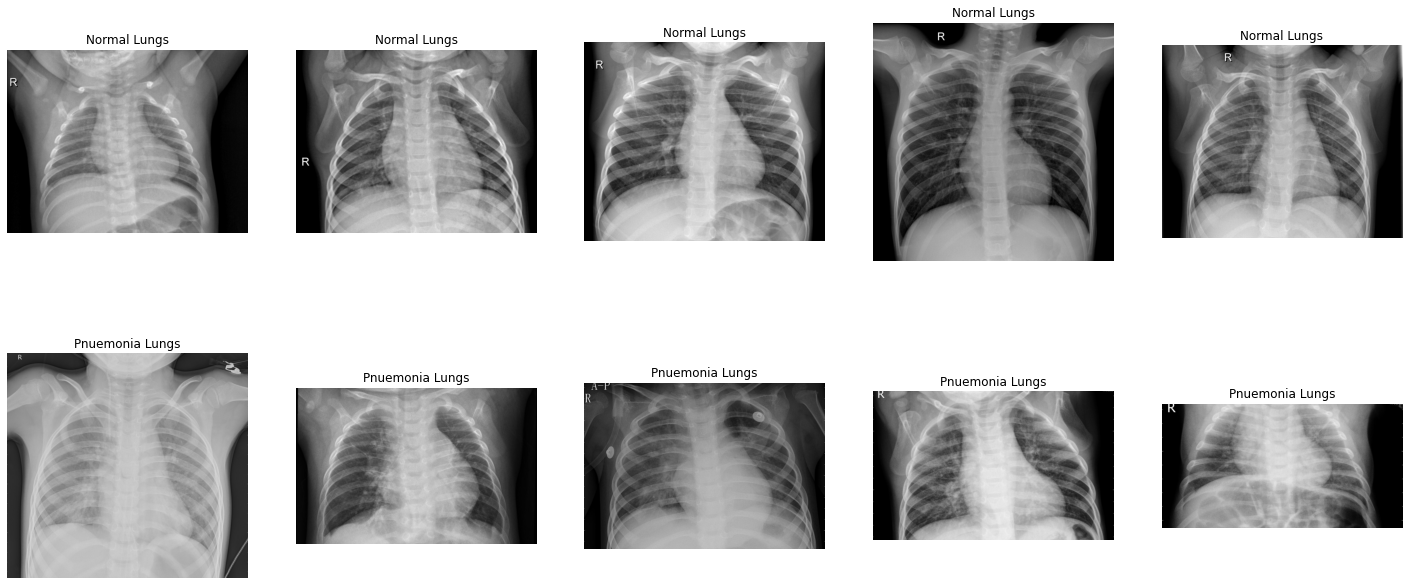

In [88]:
# Select number of images
samples = 5

# Randomly select images from both classes to inspect
pneu_imgs = np.random.choice(os.listdir(train_path + '/PNEUMONIA/'), samples, replace = False)
norm_imgs = np.random.choice(os.listdir(train_path + '/NORMAL/'), samples, replace = False)

# Preview unprocessed images sized to fit in single row (keep original aspect ratio)
plot_raw_images(norm_imgs, pneu_imgs, samples)

Without medical traing and just a visual inspection - we see somewhat more opacity in the pneumonia lungs. This could be part of the pattern the model will recognize.


In [17]:
# Check original image pixel dimensions
# Check number of pixel channels (the third dimension) to determine if RGB or grayscale

print([cv2.imread(train_path + '/NORMAL/' + img).shape for img in norm_imgs])
print([cv2.imread(train_path + '/PNEUMONIA/' + img).shape for img in pneu_imgs])

[(1299, 1624, 3), (1222, 1728, 3), (1673, 2056, 3), (1542, 1696, 3), (1568, 1696, 3)]
[(1368, 1736, 3), (616, 936, 3), (680, 1096, 3), (1168, 1760, 3), (760, 1016, 3)]


Note there is a variety in image dimensions (image size is not standardized) and there are 3 color channels. Indicating that while these X-rays appear gray, they should be treated as full RGB for the model. The resolution is too large for training resources so the images will be resized to the smallest size without sacrificing model performance.

# Modeling


### Class Imbalance




,Quantity,Proportion
Normal,1340,0.257
Pneumonia,3875,0.743


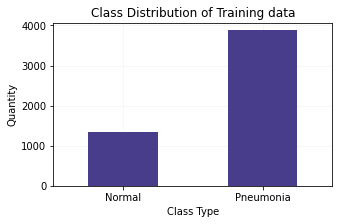



Pneumonia is represented 2.89 times as much by the data.


In [18]:
# Display proportion by class for training set
normed = get_num_images(train_path, form='normed')
total = get_num_images(train_path, form='tuple')
total_s = pd.Series(data={'Normal': total[0], 'Pneumonia': total[1]}, name= 'Quantity').to_frame()
norm_s = pd.Series(data={'Normal': normed[0], 'Pneumonia': normed[1]}, name= 'Proportion').to_frame()
class_frame = pd.concat([total_s, norm_s], axis=1)
display(class_frame)
print('\n')

# Plot the distribution as a bar graph
class_frame['Quantity'].plot.bar(figsize=(5,3), legend=False, rot=0, 
                                 color='darkslateblue', zorder=3)
plt.title('Class Distribution of Training data')
plt.xlabel("Class Type")
plt.ylabel("Quantity")
plt.grid(color="whitesmoke", zorder=0)
plt.show()

print("\n")
print(f"Pneumonia is represented {round(total[1]/total[0], 2)} times as much by the data.")

On first inspection the training data is heavily unbalanced, favoring pnuemonia images. This could skew the training of the model as it will not be sufficiently trained on what 'normal' lungs look like compared to the pneumonia lungs. Data-oversampling and class weighting are equivalent. Copying the samples of a class 3X is equivalent to assigning a 3X weight to the class. However, the weighting is better from storage and computational point of view since it avoids working with a larger data-set. I will correct this balance by calculating class weights to train the model with.

In [19]:
# Set class weights according to Keras documentation
weight_for_0 = (1 / total[0])*(get_num_images(train_path, form='total'))/2.0 
weight_for_1 = (1 / total[1])*(get_num_images(train_path, form='total'))/2.0

class_weight = {0.0: weight_for_0, 1.0: weight_for_1}

print('Weight for class 0 (Normal): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (Pnuemonia): {:.2f}'.format(weight_for_1))

Weight for class 0 (Normal): 1.95
Weight for class 1 (Pnuemonia): 0.67


### Metrics

Which type of wrong answers are most concerning?

- Accuracy is the percentage of examples correctly classified

- Precision is the percentage of predicted positives that were correctly classified

- Recall is the percentage of actual positives that were correctly classified. Model guessing all target class will get a 100% recall.

In disease screening of patients for follow-up examinations, we would probably want a recall near 1.0 — we want to find all patients who actually have the disease so treatment can begin. We can accept a low precision if the cost of the follow-up examination is not significant. However, in cases where we want to find an optimal blend of precision and recall we can combine the two metrics and check F1 score on the test set.

TARGET: Thus I will first target opttimizing the recall score. Then I will tune the model to increase precision to achieve a balanced model. My main goal will be to reduce the false predictions - which can be represented by accuracy.

In [20]:
# Set metics for use in modeling
mod_metrics = ['accuracy', 
               tf.keras.metrics.Precision(name='precision'), 
               tf.keras.metrics.Recall(name='recall')]       


### Callbacks


A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

- Early Stopping: Stop training when a monitored metric has stopped improving.

- Save model weights at some frequency or "best performance".



```python
# To save models
model.save(project_path +'model.hd5')

# Save model.history as a DataFrame
history_df.to_csv(project_path+'history_df.csv', index=False)

# Load model
model_loaded = load_model(model_path_filename)

# Load weights (that are considered the best) into the model
model.load_weights(checkpoint_filepath)

# Save model.history as a DataFrame
history_df.to_csv(project_path+'history_df.csv', index=False)
```

In [21]:
# Set baseline call backs for modeling
earlystop = callbacks.EarlyStopping(verbose=1, 
                                    monitor='val_loss', 
                                    min_delta=0, 
                                    patience=3)

checkpoint = callbacks.ModelCheckpoint(filepath=project_path+"weights.{epoch:02d}-{val_accuracy:.2f}.hdf5",
                                       save_weights_only=True, 
                                       monitor='val_loss',
                                       mode='min',
                                       save_best_only=True)

call_list = [earlystop, checkpoint]

## Modeling

Convolutional Neural Networks (CNN)


Convolutional layers 'read' the image for patterns by applying a filter to analyze each pixel. The pooling layers aggregate the findings of the convolutional layers. Therefore, each time pooling is called, the image size is reduced. 

#### Baseline CNN Preprocessing


In [22]:
# Set uniform image size, validation split percentage
target_img_size = (128, 128)
val_split_size = 0.25

# Rescale images to reduce RBG values to between 0 and 1, for easier computing
# Instantiate training set image generator
train_datagen = ImageDataGenerator(rescale=(1./255))
                                   
# Data used to train model
print(" Train:")
train_generator = train_datagen.flow_from_directory(train_path, 
                                                    target_size=target_img_size,
                                                    batch_size=128,   #get_num_images(train_path),  
                                                    class_mode='binary',
                                                    seed=seed) 

# Blind test data for model evaluation, no modifications (except rescale)
# Split into test/validation split, label the subsets
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split_size)  

# Data for use as validation in modeling to score model performance
print("\n Validation:")
val_generator = test_datagen.flow_from_directory(test_path, 
                                                      target_size=target_img_size,
                                                      class_mode='binary',
                                                      batch_size=get_num_images(test_path),
                                                      subset='validation', 
                                                      seed=seed) 

# Data for testing completed model
print("\n Test:")
test_generator = test_datagen.flow_from_directory(test_path, 
                                                      target_size=target_img_size,
                                                      class_mode='binary',
                                                      batch_size=get_num_images(test_path),
                                                      subset='training',
                                                      seed=seed)  

# Check for class types
print("\n Class Types:", train_generator.class_indices )

 Train:
Found 5215 images belonging to 2 classes.

 Validation:
Found 155 images belonging to 2 classes.

 Test:
Found 469 images belonging to 2 classes.

 Class Types: {'NORMAL': 0, 'PNEUMONIA': 1}


In [23]:
# Format test images for evaluation
test_images, test_labels = next(test_generator)
print("Test Check:", len(test_images), len(test_labels))

# Verify single image size output by the generator 
input_image_size = test_images[0].shape
input_image_size

Test Check: 469 469


(128, 128, 3)

### Building a baseline

Aim to find the basic arcitecture/depth for this dataset that maximizes recall.

#### Iteration 1 : Baseline CNN

I will begin with one convolution block of two convolution layers to check baseline metrics. Then I will grow the model until it is just over fit. Then I will tune/early stop to reduce validation loss. Hopefully bringing overall model perfomance to a balanced predictions.

In [24]:
# Instantiate model
cnn = Sequential()

# First Conv layer
cnn.add(Conv2D(128, (3, 3), input_shape = input_image_size, activation = 'relu'))
cnn.add(Conv2D(64, (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the Conv layers for input into dense layer
cnn.add(Flatten())

# A hidden dense layer followed by the final binary classifying neuron
cnn.add(Dense(units = 128, activation = 'relu'))
cnn.add(Dense(units = 1, activation = 'sigmoid'))

# Compile the model and check architecture
cnn.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

# Preview model arhitecture
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      73792     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               31490176  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 31,567,681
Trainable params: 31,567,681
Non-trainable params: 0
____________________________________________

In [ ]:
# Train the model
# history = cnn.fit(train_generator, 
                              batch_size=64, 
                              epochs=10, 
                              validation_data=val_generator,
                              class_weight=class_weight)
                              #callbacks=call_list)

Epoch 1/10
41/41 [==============================] - 56s 1s/step - loss: 1.2154 - accuracy: 0.7337 - precision: 0.8992 - recall: 0.7226 - val_loss: 0.5475 - val_accuracy: 0.7290 - val_precision: 0.6978 - val_recall: 1.0000
Epoch 2/10
41/41 [==============================] - 55s 1s/step - loss: 0.1498 - accuracy: 0.9411 - precision: 0.9822 - recall: 0.9378 - val_loss: 1.0480 - val_accuracy: 0.6710 - val_precision: 0.6554 - val_recall: 1.0000
Epoch 3/10
41/41 [==============================] - 54s 1s/step - loss: 0.1308 - accuracy: 0.9530 - precision: 0.9835 - recall: 0.9528 - val_loss: 0.6301 - val_accuracy: 0.7871 - val_precision: 0.7462 - val_recall: 1.0000
Epoch 4/10
41/41 [==============================] - 54s 1s/step - loss: 0.0857 - accuracy: 0.9682 - precision: 0.9889 - recall: 0.9680 - val_loss: 0.4084 - val_accuracy: 0.8323 - val_precision: 0.7886 - val_recall: 1.0000
Epoch 5/10
41/41 [==============================] - 54s 1s/step - loss: 0.0699 - accuracy: 0.9734 - precision: 0

------------------------------------------------------------
Classification Report for Test Data: 

              precision    recall  f1-score   support

         0.0       0.97      0.34      0.50       176
         1.0       0.71      0.99      0.83       293

    accuracy                           0.75       469
   macro avg       0.84      0.66      0.66       469
weighted avg       0.81      0.75      0.71       469

------------------------------------------------------------
15/15 [==============================] - 0s 9ms/step - loss: 1.3906 - accuracy: 0.7463 - precision: 0.7132 - recall: 0.9932
Loss of the model is -  1.390621304512024
15/15 [==============================] - 0s 9ms/step - loss: 1.3906 - accuracy: 0.7463 - precision: 0.7132 - recall: 0.9932
Accuracy of the model is -  74.6268630027771 %
------------------------------------------------------------
Correct: 350, 74.63%
Incorrect: 119, 25.37%
------------------------------------------------------------
Model Pre

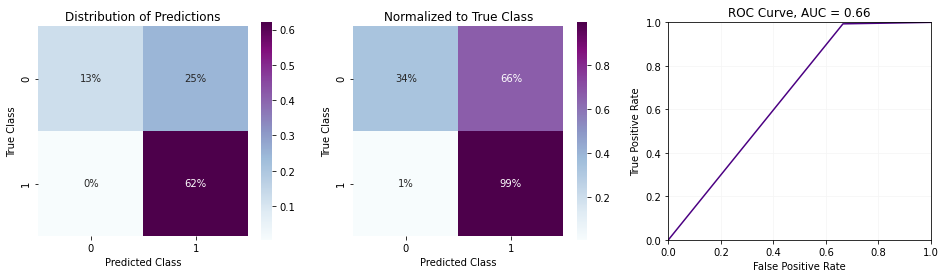

None

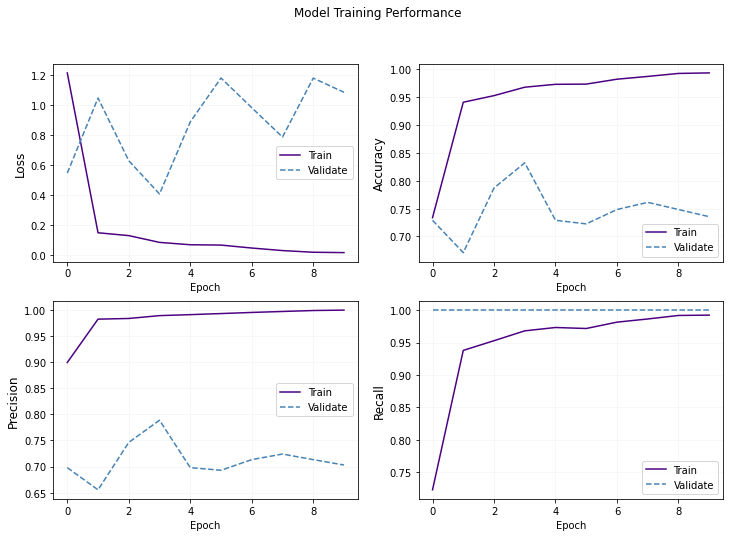

In [31]:
# Load model, history
# cnn = load_model(project_path +'cnn.hd5')
# history_df = pd.read_csv(project_path + 'history_df.csv')
display(evaluate_model(cnn, test_images, test_labels))
plot_history_df(history_df)

# # Evaluate model performance
# display(evaluate_model(cnn, test_images, test_labels))
# history_df = plot_metrics(history, df=True)

# # To save model and model.history as a DataFrame
# cnn.save(project_path +'cnn')
# history_df.to_csv(project_path+'history_df.csv', index=False)

This shallow network is almost labeling pneumonia 87% (25% false positives + 62% true positives) of predictions. This gives a misleading 99% recall. 66% of normal lungs are being misclassified. I have used class weights to try and nudge it into learning normal lungs. Will attempt more tuning to raise the number of normal predictions.

#### Iteration 2 : Add second convolutional layer

In [ ]:
# Adding another pooling later between convolutions and reduce dense layer
cnn2 = Sequential([Conv2D(128, (3, 3), input_shape = input_image_size, activation = 'relu'),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(64, kernel_size=(5, 5), activation='relu'),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Flatten(),
                  Dense(64, activation='relu'),
                  Dense(1, activation = 'sigmoid')])

# Compile model
cnn2.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

In [ ]:
# Fit model
# history2 = cnn2.fit(train_generator,
                              batch_size =64,
                              epochs = 10, 
                              validation_data = val_generator,
                              callbacks = call_list,
                              class_weight=class_weight)
                              

Epoch 1/10
41/41 [==============================] - 57s 1s/step - loss: 0.4734 - accuracy: 0.7504 - precision: 0.9192 - recall: 0.7280 - val_loss: 0.6120 - val_accuracy: 0.7161 - val_precision: 0.6879 - val_recall: 1.0000
Epoch 2/10
41/41 [==============================] - 52s 1s/step - loss: 0.1922 - accuracy: 0.9235 - precision: 0.9715 - recall: 0.9241 - val_loss: 0.5290 - val_accuracy: 0.8000 - val_precision: 0.7705 - val_recall: 0.9691
Epoch 3/10
41/41 [==============================] - 52s 1s/step - loss: 0.1272 - accuracy: 0.9511 - precision: 0.9842 - recall: 0.9494 - val_loss: 0.6535 - val_accuracy: 0.7742 - val_precision: 0.7348 - val_recall: 1.0000
Epoch 4/10
41/41 [==============================] - 51s 1s/step - loss: 0.0969 - accuracy: 0.9638 - precision: 0.9878 - recall: 0.9631 - val_loss: 0.6577 - val_accuracy: 0.7677 - val_precision: 0.7364 - val_recall: 0.9794
Epoch 5/10
41/41 [==============================] - 51s 1s/step - loss: 0.0927 - accuracy: 0.9640 - precision: 0

------------------------------------------------------------
Classification Report for Test Data: 

              precision    recall  f1-score   support

         0.0       0.88      0.62      0.73       176
         1.0       0.81      0.95      0.87       293

    accuracy                           0.83       469
   macro avg       0.84      0.79      0.80       469
weighted avg       0.84      0.83      0.82       469

------------------------------------------------------------
15/15 [==============================] - 0s 8ms/step - loss: 0.4965 - accuracy: 0.8273 - precision: 0.8081 - recall: 0.9488
Loss of the model is -  0.4965476393699646
15/15 [==============================] - 0s 8ms/step - loss: 0.4965 - accuracy: 0.8273 - precision: 0.8081 - recall: 0.9488
Accuracy of the model is -  82.72920846939087 %
------------------------------------------------------------
Correct: 388, 82.73%
Incorrect: 81, 17.27%
------------------------------------------------------------
Model Pr

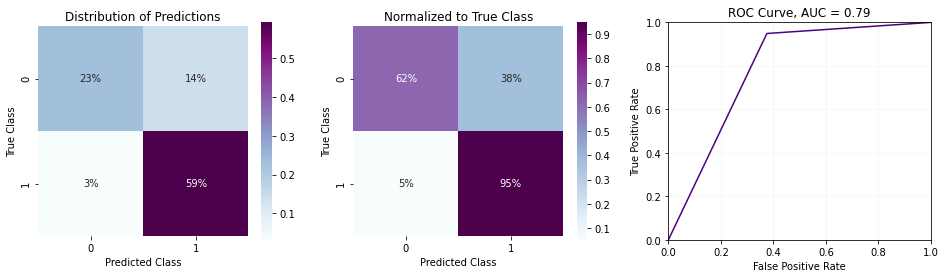

None

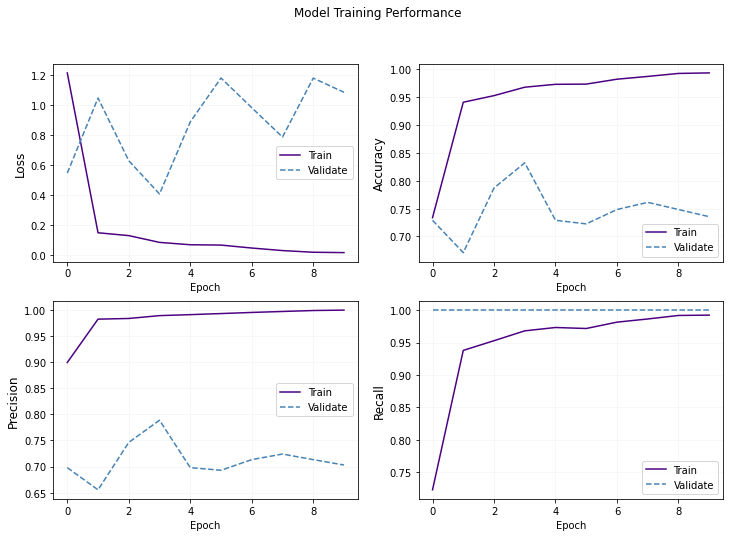

In [32]:
# Load model, history
cnn2 = load_model(project_path +'cnn2')
history2_df = pd.read_csv(project_path + 'history2_df.csv')
display(evaluate_model(cnn2, test_images, test_labels))
plot_history_df(history2_df)

# # Evaluate model performance
# display(evaluate_model(cnn2, test_images, test_labels))
# history2_df = plot_metrics(history2, df=True)

# # To save model and model.history as a DataFrame
# cnn2.save(project_path +'cnn2')
# history2_df.to_csv(project_path+'history2_df.csv', index=False)

The second layer has improved AUC from 0.66 to 0.79 (13 points). We do not see convergence of the training and validation data, indicating model is still overfitting. False positives has shrunk as well. Making progress.

#### Iteration 3: Add third convolution layer

In [ ]:
cnn3 = Sequential([Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_image_size),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(64, kernel_size=(5, 5), activation='relu'),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(32, kernel_size=(5, 5), activation='relu'),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Flatten(),
                  Dense(64, activation='relu'),
                  Dense(1, activation = 'sigmoid')])

cnn3.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

In [ ]:
# history3 = cnn3.fit(train_generator,
                              batch_size =64,
                              epochs = 10, 
                              validation_data = val_generator,
                              callbacks = call_list,
                              class_weight=class_weight)

Epoch 1/10
41/41 [==============================] - 56s 1s/step - loss: 0.5044 - accuracy: 0.7295 - precision: 0.8797 - recall: 0.7438 - val_loss: 0.2443 - val_accuracy: 0.8903 - val_precision: 0.9000 - val_recall: 0.9278
Epoch 2/10
41/41 [==============================] - 54s 1s/step - loss: 0.1870 - accuracy: 0.9262 - precision: 0.9763 - recall: 0.9231 - val_loss: 0.2672 - val_accuracy: 0.8903 - val_precision: 0.9651 - val_recall: 0.8557
Epoch 3/10
41/41 [==============================] - 53s 1s/step - loss: 0.1555 - accuracy: 0.9377 - precision: 0.9792 - recall: 0.9360 - val_loss: 0.3209 - val_accuracy: 0.8516 - val_precision: 0.8190 - val_recall: 0.9794
Epoch 4/10
41/41 [==============================] - 54s 1s/step - loss: 0.1181 - accuracy: 0.9517 - precision: 0.9876 - recall: 0.9468 - val_loss: 0.8595 - val_accuracy: 0.7548 - val_precision: 0.7218 - val_recall: 0.9897
Epoch 5/10
41/41 [==============================] - 55s 1s/step - loss: 0.0953 - accuracy: 0.9605 - precision: 0

------------------------------------------------------------
Classification Report for Test Data: 

              precision    recall  f1-score   support

         0.0       0.94      0.48      0.64       176
         1.0       0.76      0.98      0.86       293

    accuracy                           0.80       469
   macro avg       0.85      0.73      0.75       469
weighted avg       0.83      0.80      0.78       469

------------------------------------------------------------
15/15 [==============================] - 0s 7ms/step - loss: 0.7443 - accuracy: 0.7953 - precision: 0.7599 - recall: 0.9829
Loss of the model is -  0.7442617416381836
15/15 [==============================] - 0s 8ms/step - loss: 0.7443 - accuracy: 0.7953 - precision: 0.7599 - recall: 0.9829
Accuracy of the model is -  79.53091859817505 %
------------------------------------------------------------
Correct: 373, 79.53%
Incorrect: 96, 20.47%
------------------------------------------------------------
Model Pr

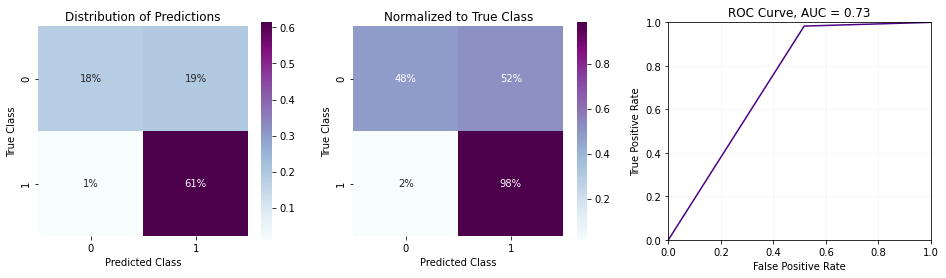

None

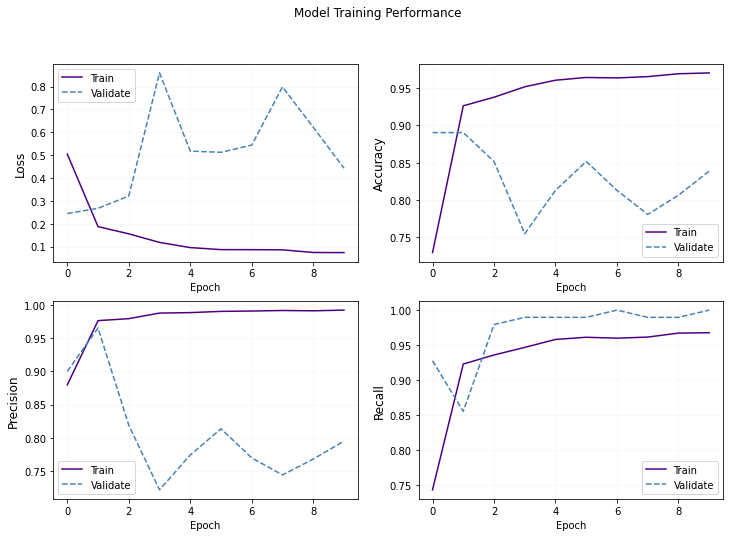

In [33]:
# Load model, history
cnn3 = load_model(project_path +'cnn3')
history3_df = pd.read_csv(project_path + 'history3_df.csv')
display(evaluate_model(cnn3, test_images, test_labels))
plot_history_df(history3_df)

# # Evaluate model performance
# display(evaluate_model(cnn3, test_images, test_labels))
# history3_df = plot_metrics(history3, df=True)

# # To save model and model.history as a DataFrame
# cnn3.save(project_path +'cnn3')
# history3_df.to_csv(project_path+'history3_df.csv', index=False)

Ability to predict normal lungs has actually decreased with a deepr network.

#### Iteration 4: Double up convolution layers before pooling


In [ ]:
cnn4 = Sequential([Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_image_size),
                  Conv2D(64, kernel_size=(5, 5), activation='relu'),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(64, kernel_size=(5, 5), activation='relu'),
                  Conv2D(32, kernel_size=(5, 5), activation='relu'),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(32, kernel_size=(5, 5), activation='relu'),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Flatten(),
                  Dense(32, activation='relu'),
                  Dense(1, activation = 'sigmoid')])

cnn4.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

# history4 = cnn4.fit(train_generator,
                              batch_size =64
                              epochs = 10, 
                              validation_data = val_generator,
                              callbacks = call_list,
                              class_weight=class_weight)


Epoch 1/10
41/41 [==============================] - 58s 1s/step - loss: 0.4858 - accuracy: 0.7423 - precision: 0.8810 - recall: 0.7567 - val_loss: 0.1996 - val_accuracy: 0.9161 - val_precision: 0.9118 - val_recall: 0.9588
Epoch 2/10
41/41 [==============================] - 55s 1s/step - loss: 0.2054 - accuracy: 0.9126 - precision: 0.9698 - recall: 0.9107 - val_loss: 0.4821 - val_accuracy: 0.8323 - val_precision: 0.7934 - val_recall: 0.9897
Epoch 3/10
41/41 [==============================] - 54s 1s/step - loss: 0.1829 - accuracy: 0.9224 - precision: 0.9730 - recall: 0.9210 - val_loss: 0.6345 - val_accuracy: 0.7419 - val_precision: 0.7080 - val_recall: 1.0000
Epoch 4/10
41/41 [==============================] - 54s 1s/step - loss: 0.1515 - accuracy: 0.9396 - precision: 0.9790 - recall: 0.9388 - val_loss: 0.6662 - val_accuracy: 0.7677 - val_precision: 0.7293 - val_recall: 1.0000
Epoch 5/10
41/41 [==============================] - 54s 1s/step - loss: 0.1692 - accuracy: 0.9354 - precision: 0

------------------------------------------------------------
Classification Report for Test Data: 

              precision    recall  f1-score   support

         0.0       0.88      0.39      0.54       176
         1.0       0.72      0.97      0.83       293

    accuracy                           0.75       469
   macro avg       0.80      0.68      0.68       469
weighted avg       0.78      0.75      0.72       469

------------------------------------------------------------
15/15 [==============================] - 0s 12ms/step - loss: 0.7964 - accuracy: 0.7505 - precision: 0.7245 - recall: 0.9693
Loss of the model is -  0.7963775396347046
15/15 [==============================] - 0s 13ms/step - loss: 0.7964 - accuracy: 0.7505 - precision: 0.7245 - recall: 0.9693
Accuracy of the model is -  75.05330443382263 %
------------------------------------------------------------
Correct: 352, 75.05%
Incorrect: 117, 24.95%
------------------------------------------------------------
Model

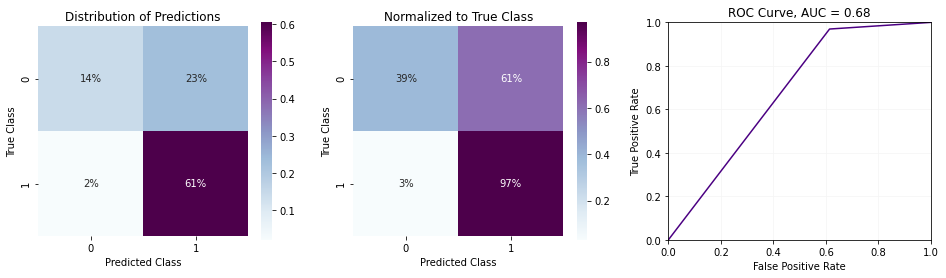

None

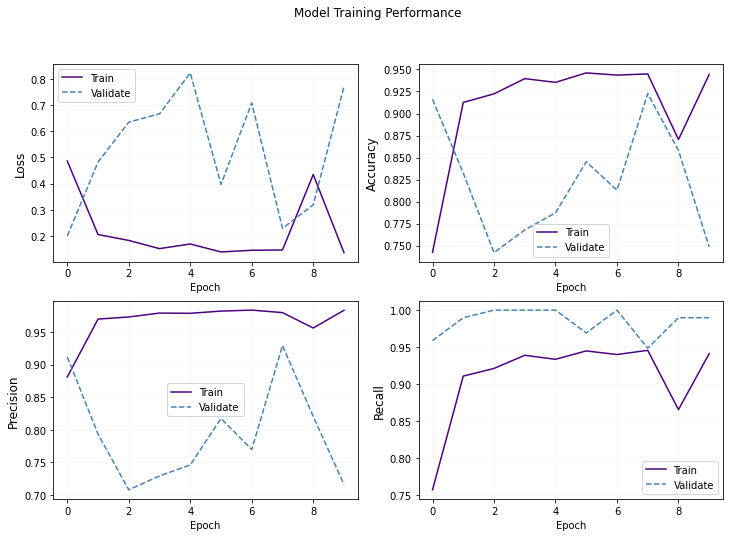

In [34]:
# Load model, history
cnn4 = load_model(project_path +'cnn4')
history4_df = pd.read_csv(project_path + 'history4_df.csv')
display(evaluate_model(cnn4, test_images, test_labels))
plot_history_df(history4_df)

# # Evaluate model performance
# display(evaluate_model(cnn4, test_images, test_labels))
# history4_df = plot_metrics(history4, df=True)

# # To save model and model.history as a DataFrame
# cnn4.save(project_path +'cnn4')
# history4_df.to_csv(project_path+'history4_df.csv', index=False)

#### Iteration 5: Five convolutional layers

In [ ]:
cnn5 = Sequential([Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_image_size),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(128, kernel_size=(3, 3), activation='relu'), 
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(64, kernel_size=(3, 3), activation='relu'),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(64, kernel_size=(3, 3), activation='relu'),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(32, kernel_size=(3, 3), activation='relu'),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Flatten(),
                  Dense(64, activation='relu'),
                  Dense(1, activation = 'sigmoid')])

cnn5.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

In [ ]:
# history5 = cnn5.fit(train_generator,
                              epochs = 10, 
                              validation_data = val_generator,
                              callbacks = call_list,
                              class_weight=class_weight)

Epoch 1/10
41/41 [==============================] - 52s 1s/step - loss: 0.5430 - accuracy: 0.6716 - precision: 0.8566 - recall: 0.6737 - val_loss: 0.3057 - val_accuracy: 0.8774 - val_precision: 0.9432 - val_recall: 0.8557
Epoch 2/10
41/41 [==============================] - 50s 1s/step - loss: 0.2778 - accuracy: 0.8896 - precision: 0.9604 - recall: 0.8880 - val_loss: 0.2847 - val_accuracy: 0.8710 - val_precision: 0.8468 - val_recall: 0.9691
Epoch 3/10
41/41 [==============================] - 50s 1s/step - loss: 0.2088 - accuracy: 0.9156 - precision: 0.9746 - recall: 0.9102 - val_loss: 0.8335 - val_accuracy: 0.6968 - val_precision: 0.6736 - val_recall: 1.0000
Epoch 4/10
41/41 [==============================] - 51s 1s/step - loss: 0.1667 - accuracy: 0.9314 - precision: 0.9762 - recall: 0.9303 - val_loss: 0.7835 - val_accuracy: 0.7097 - val_precision: 0.6831 - val_recall: 1.0000
Epoch 5/10
41/41 [==============================] - 51s 1s/step - loss: 0.1433 - accuracy: 0.9427 - precision: 0

------------------------------------------------------------
Classification Report for Test Data: 

              precision    recall  f1-score   support

         0.0       0.94      0.57      0.71       176
         1.0       0.79      0.98      0.87       293

    accuracy                           0.83       469
   macro avg       0.86      0.77      0.79       469
weighted avg       0.85      0.83      0.81       469

------------------------------------------------------------
15/15 [==============================] - 0s 9ms/step - loss: 0.5082 - accuracy: 0.8252 - precision: 0.7922 - recall: 0.9761
Loss of the model is -  0.5082361102104187
15/15 [==============================] - 0s 7ms/step - loss: 0.5082 - accuracy: 0.8252 - precision: 0.7922 - recall: 0.9761
Accuracy of the model is -  82.51599073410034 %
------------------------------------------------------------
Correct: 387, 82.52%
Incorrect: 82, 17.48%
------------------------------------------------------------
Model Pr

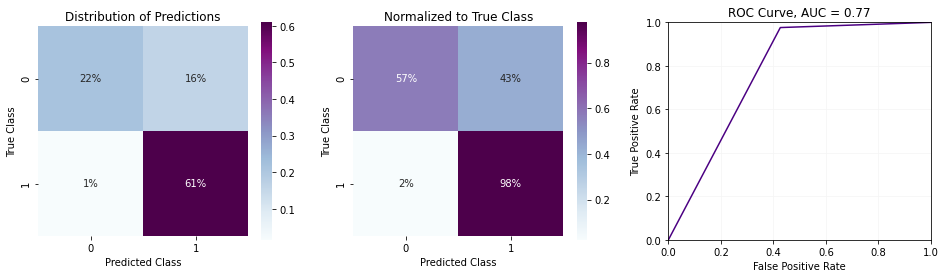

None

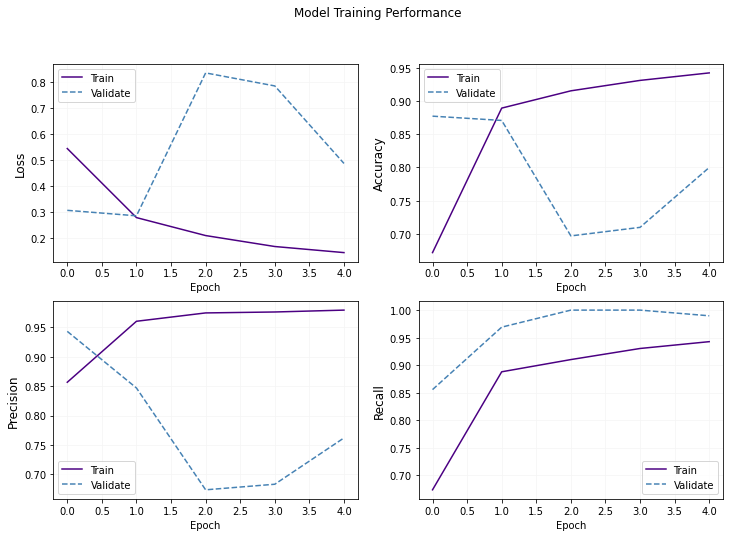

In [35]:
# Load model, history
cnn5 = load_model(project_path +'cnn5')
history5_df = pd.read_csv(project_path + 'history5_df.csv')
display(evaluate_model(cnn5, test_images, test_labels))
plot_history_df(history5_df)

# # Evaluate model performance
# display(evaluate_model(cnn5, test_images, test_labels))
# history5_df = plot_metrics(history5, df=True)

# # To save model and model.history as a DataFrame
# cnn5.save(project_path +'cnn5')
# history5_df.to_csv(project_path+'history5_df.csv', index=False)

### Tuning

Based on the variety of baseling structure above, I choose to move forward with tuning models 'cnn2' (AUC 0.79, accuracy 82%) and 'cnn3' (AUC 0.73, accuracy). Most models had high recall for predicting pneumonia and were overfit to training data. I selected models 2 and 3 as baseline due to the improved score for predicting normal lungs and higher AUC. I will now try to reduce overfitting. And continue to reduce false predictions.

#### Iteration 6 : Add drop out layers



Epoch 1/10
41/41 [==============================] - 57s 1s/step - loss: 0.5513 - accuracy: 0.7722 - precision: 0.9394 - recall: 0.8456 - val_loss: 0.2976 - val_accuracy: 0.8645 - val_precision: 0.8455 - val_recall: 0.9588
Epoch 2/10
41/41 [==============================] - 55s 1s/step - loss: 0.1680 - accuracy: 0.9356 - precision: 0.9779 - recall: 0.9345 - val_loss: 0.5559 - val_accuracy: 0.7613 - val_precision: 0.7239 - val_recall: 1.0000
Epoch 3/10
41/41 [==============================] - 55s 1s/step - loss: 0.1167 - accuracy: 0.9563 - precision: 0.9851 - recall: 0.9556 - val_loss: 0.4405 - val_accuracy: 0.7935 - val_precision: 0.7519 - val_recall: 1.0000
Epoch 4/10
41/41 [==============================] - 55s 1s/step - loss: 0.1143 - accuracy: 0.9565 - precision: 0.9848 - recall: 0.9561 - val_loss: 0.5022 - val_accuracy: 0.7742 - val_precision: 0.7348 - val_recall: 1.0000
Epoch 5/10
41/41 [==============================] - 55s 1s/step - loss: 0.0960 - accuracy: 0.9636 - precision: 0

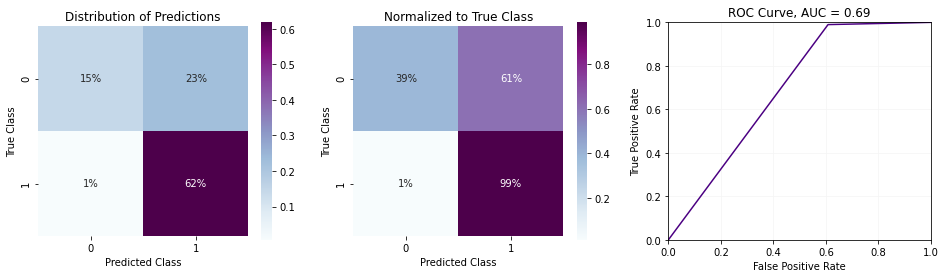

None

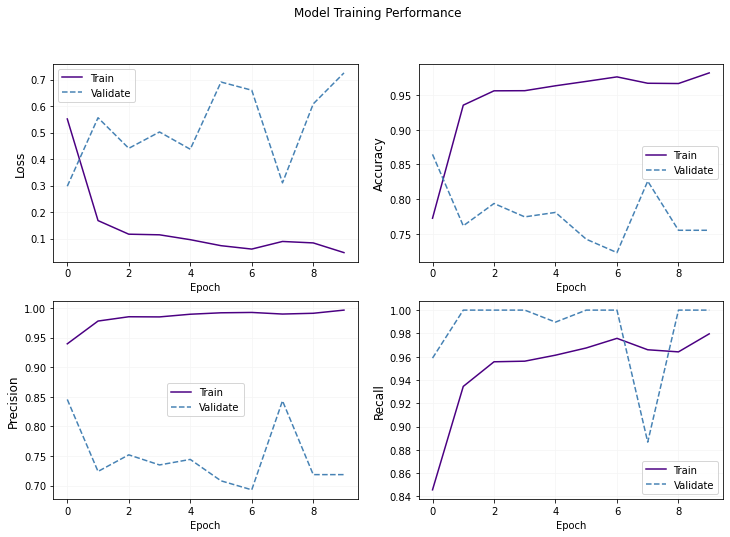

In [ ]:
# Add drop out layer to model 2
cnn2_do = Sequential([Conv2D(128, (3, 3), input_shape = input_image_size, activation = 'relu'),
                      Dropout(0.2),
                      MaxPooling2D(pool_size=(2, 2), strides=2),
                      Conv2D(64, kernel_size=(5, 5), activation='relu'),
                      Dropout(0.2),
                      MaxPooling2D(pool_size=(2, 2), strides=2),
                      Flatten(),
                      Dense(64, activation='relu'),
                      Dense(1, activation = 'sigmoid')])

# Compile model
cnn2_do.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

# history2_do = cnn2_do.fit(train_generator,
                              epochs = 10, 
                              validation_data = val_generator,
                              #callbacks = call_list,
                              class_weight=class_weight)

display(evaluate_model(cnn2_do, test_images, test_labels))
plot_metrics(history2_do)

Epoch 1/10
41/41 [==============================] - 56s 1s/step - loss: 0.4722 - accuracy: 0.7373 - precision: 0.8746 - recall: 0.6752 - val_loss: 0.3153 - val_accuracy: 0.8903 - val_precision: 0.8846 - val_recall: 0.9485
Epoch 2/10
41/41 [==============================] - 54s 1s/step - loss: 0.1677 - accuracy: 0.9352 - precision: 0.9776 - recall: 0.9342 - val_loss: 0.3044 - val_accuracy: 0.8645 - val_precision: 0.8333 - val_recall: 0.9794
Epoch 3/10
41/41 [==============================] - 54s 1s/step - loss: 0.1092 - accuracy: 0.9594 - precision: 0.9867 - recall: 0.9582 - val_loss: 0.3152 - val_accuracy: 0.8452 - val_precision: 0.8067 - val_recall: 0.9897
Epoch 4/10
41/41 [==============================] - 54s 1s/step - loss: 0.1152 - accuracy: 0.9542 - precision: 0.9864 - recall: 0.9515 - val_loss: 0.4349 - val_accuracy: 0.7871 - val_precision: 0.7500 - val_recall: 0.9897
Epoch 5/10
41/41 [==============================] - 54s 1s/step - loss: 0.0916 - accuracy: 0.9651 - precision: 0

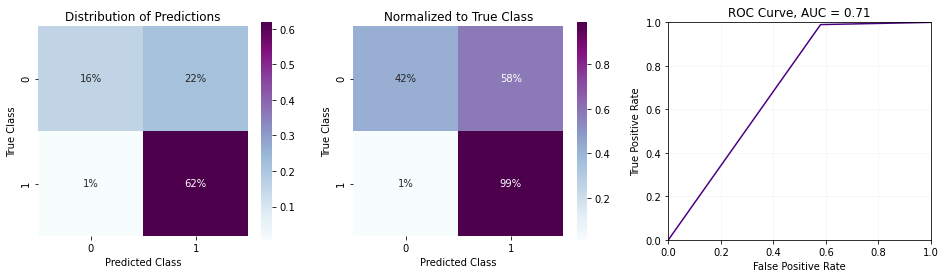

None

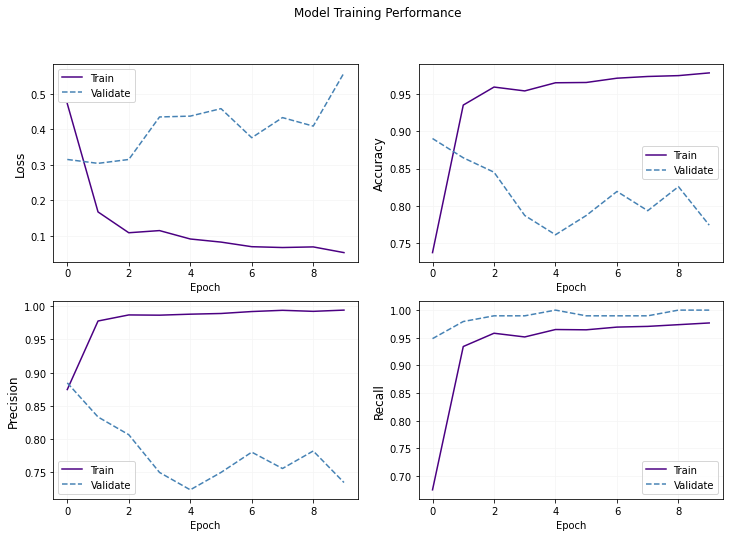

In [ ]:
# Add drop out layers to model 3
cnn3_do = Sequential([Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_image_size),
                  Dropout(0.2),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(64, kernel_size=(3, 3), activation='relu'),
                  Dropout(0.2),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(32, kernel_size=(3, 3), activation='relu'),
                  Dropout(0.2),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Flatten(),
                  Dense(32, activation='relu'),
                  Dense(1, activation = 'sigmoid')])

cnn3_do.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

# history3_do = cnn3_do.fit(train_generator,
                              epochs = 10, 
                              validation_data = val_generator,
                              #callbacks = call_list,
                              class_weight=class_weight)

display(evaluate_model(cnn3_do, test_images, test_labels))
plot_metrics(history3_do)

Epoch 1/10
41/41 [==============================] - 51s 1s/step - loss: 0.5552 - accuracy: 0.7172 - precision: 0.8925 - recall: 0.7214 - val_loss: 0.5271 - val_accuracy: 0.8452 - val_precision: 0.8017 - val_recall: 1.0000
Epoch 2/10
41/41 [==============================] - 49s 1s/step - loss: 0.3410 - accuracy: 0.8683 - precision: 0.9541 - recall: 0.8643 - val_loss: 0.4382 - val_accuracy: 0.9355 - val_precision: 0.9780 - val_recall: 0.9175
Epoch 3/10
41/41 [==============================] - 49s 1s/step - loss: 0.2456 - accuracy: 0.8976 - precision: 0.9660 - recall: 0.8937 - val_loss: 0.3639 - val_accuracy: 0.9161 - val_precision: 0.8889 - val_recall: 0.9897
Epoch 4/10
41/41 [==============================] - 49s 1s/step - loss: 0.1949 - accuracy: 0.9206 - precision: 0.9740 - recall: 0.9177 - val_loss: 0.2996 - val_accuracy: 0.9097 - val_precision: 0.8879 - val_recall: 0.9794
Epoch 5/10
41/41 [==============================] - 49s 1s/step - loss: 0.1733 - accuracy: 0.9348 - precision: 0

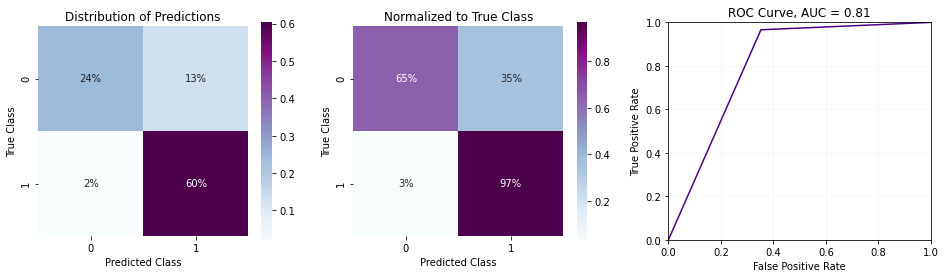

None

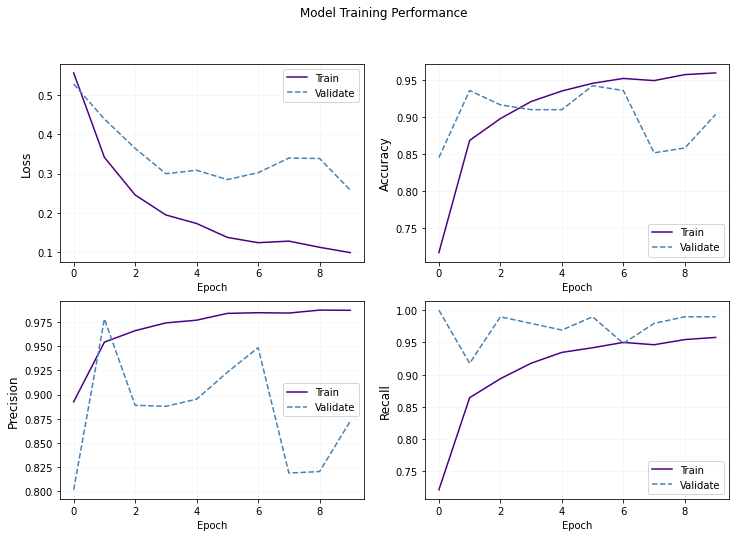

In [ ]:
cnn5_do = Sequential([Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_image_size),
                      Dropout(0.2),
                      MaxPooling2D(pool_size=(2, 2), strides=2),
                      Conv2D(128, kernel_size=(3, 3), activation='relu'), 
                      Dropout(0.2),
                      MaxPooling2D(pool_size=(2, 2), strides=2),
                      Conv2D(64, kernel_size=(3, 3), activation='relu'),
                      Dropout(0.2),
                      MaxPooling2D(pool_size=(2, 2), strides=2),
                      Conv2D(64, kernel_size=(3, 3), activation='relu'),
                      Dropout(0.2),
                      MaxPooling2D(pool_size=(2, 2), strides=2),
                      Conv2D(32, kernel_size=(3, 3), activation='relu'),
                      Dropout(0.2),
                      MaxPooling2D(pool_size=(2, 2), strides=2),
                      Flatten(),
                      Dense(64, activation='relu'),
                      Dense(1, activation = 'sigmoid')])

cnn5_do.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

# history5_do = cnn5_do.fit(train_generator,
                              epochs = 10, 
                              validation_data = val_generator,
                              #callbacks = call_list,
                              class_weight=class_weight)

display(evaluate_model(cnn5_do, test_images, test_labels))
plot_metrics(history5_do)

With dropout: AUC, and F1 score also improved. I will continue tuning this model. My aim is to improve the 50/50 split on normal lung (increase precision). Will NOT be proceeding with model 2. Continue tuning 3 and 5.

#### Iteration 7 : Image Augmentation
Data augmentation is the process of changing the training samples and adding them back into the set. It is used for enriching the diversity of training samples and helped the model discern noise. I did not choose flipping, as the ocation of organs is important and all X-rays are to be anterior-posterior in orientation. Augmentation is especially important if image source is not constant - this can train the model for instances of low quality or different body shapes.

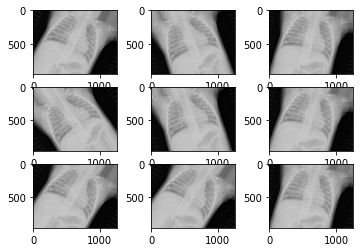

In [76]:
# Preview image augmentations (select SINGLE modification per call)
datagenerator = ImageDataGenerator(rotation_range =35)
show_data_augmentation(datagenerator)

In [41]:
# Instantiate training set image generator with data augmentation
train_datagen_aug = ImageDataGenerator(rescale=(1./255),
                                          rotation_range = 20,  # Randomly rotate images
                                          zoom_range = 0.2, # Randomly zoom image 
                                          width_shift_range=0.1,  # Randomly shift images horizontally
                                          height_shift_range=0.1,  # Randomly shift images vertically
                                          brightness_range=[0.8,1.2]) # Randomly change brightness in range
                                                            

# Data used to train model
print(" Train:")
train_data_aug = train_datagen_aug.flow_from_directory(train_path, 
                                                    target_size=target_img_size,
                                                    batch_size=64, #get_num_images(train_path))  
                                                    class_mode='binary',
                                                    seed=seed)
                                                                                                                                    

 Train:
Found 5215 images belonging to 2 classes.


In [ ]:
cnn3_do_aug = Sequential([Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_image_size),
                  Dropout(0.2),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(64, kernel_size=(3, 3), activation='relu'),
                  Dropout(0.2),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(32, kernel_size=(3, 3), activation='relu'),
                  Dropout(0.2),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Flatten(),
                  Dense(32, activation='relu'),
                  Dense(1, activation = 'sigmoid')])

cnn3_do_aug.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

# history3_do_aug = cnn3_do_aug.fit(train_data_aug,
                                  batch_size=64
                                  epochs = 30, 
                                  validation_data = val_generator,
                                  callbacks = checkpoint,
                                  class_weight=class_weight)


Epoch 1/15
82/82 [==============================] - 72s 877ms/step - loss: 0.1895 - accuracy: 0.9279 - precision: 0.9774 - recall: 0.9244 - val_loss: 0.2107 - val_accuracy: 0.9355 - val_precision: 0.9143 - val_recall: 0.9897
Epoch 2/15
82/82 [==============================] - 71s 866ms/step - loss: 0.1854 - accuracy: 0.9250 - precision: 0.9773 - recall: 0.9205 - val_loss: 0.2104 - val_accuracy: 0.9161 - val_precision: 0.8818 - val_recall: 1.0000
Epoch 3/15
82/82 [==============================] - 71s 870ms/step - loss: 0.1942 - accuracy: 0.9248 - precision: 0.9747 - recall: 0.9228 - val_loss: 0.1877 - val_accuracy: 0.9484 - val_precision: 0.9495 - val_recall: 0.9691
Epoch 4/15
82/82 [==============================] - 71s 867ms/step - loss: 0.1747 - accuracy: 0.9314 - precision: 0.9795 - recall: 0.9270 - val_loss: 0.1899 - val_accuracy: 0.9355 - val_precision: 0.9780 - val_recall: 0.9175
Epoch 5/15
82/82 [==============================] - 71s 867ms/step - loss: 0.1616 - accuracy: 0.9404

------------------------------------------------------------
Classification Report for Test Data: 

              precision    recall  f1-score   support

         0.0       0.87      0.76      0.81       176
         1.0       0.87      0.93      0.90       293

    accuracy                           0.87       469
   macro avg       0.87      0.85      0.86       469
weighted avg       0.87      0.87      0.87       469

------------------------------------------------------------
15/15 [==============================] - 0s 8ms/step - loss: 0.3666 - accuracy: 0.8678 - precision: 0.8667 - recall: 0.9317
Loss of the model is -  0.3666452169418335
15/15 [==============================] - 0s 7ms/step - loss: 0.3666 - accuracy: 0.8678 - precision: 0.8667 - recall: 0.9317
Accuracy of the model is -  86.78038120269775 %
------------------------------------------------------------
Correct: 407, 86.78%
Incorrect: 62, 13.22%
------------------------------------------------------------
Model Pr

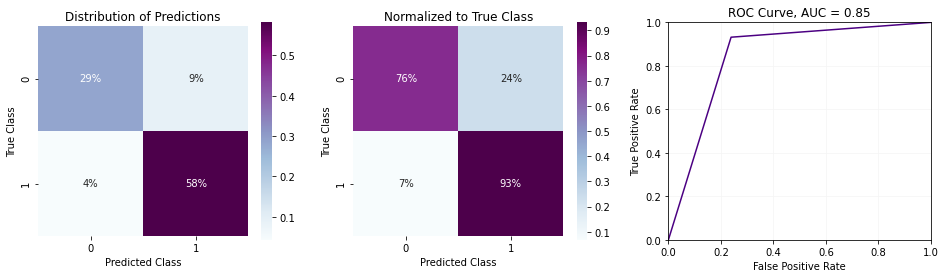

None

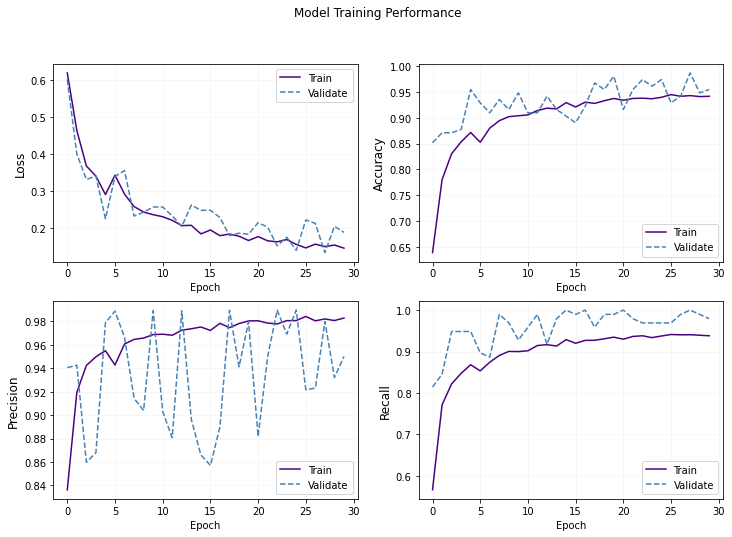

In [42]:
# Load model, history
cnn3_do_aug = load_model(project_path +'cnn3_do_aug')
history3_do_aug_df = pd.read_csv(project_path + 'history3_do_aug_df.csv')
display(evaluate_model(cnn3_do_aug, test_images, test_labels))
plot_history_df(history3_do_aug_df)

# # Evaluate model performance
# display(evaluate_model(cnn3_do_aug, test_images, test_labels))
# history3_do_aug_df = plot_metrics(history3_do_aug, df=True)

# # To save model and model.history as a DataFrame
# cnn3_do_aug.save(project_path +'cnn3_do_aug')
# history3_do_aug_df.to_csv(project_path+'history3_do_aug_df.csv', index=False)

Alright! Some of the metrics are begining to converge. Accuracy has improved to 86% and AUC to 0.83. I am mostly pleased to see the true negative class (the class I was optimizing for) has improved to 76% correct, while maintaining a true positive of 93%. Let's see if I can tighten it up a bit more - I also think that this model could have ran longer. 

#### Iteration 8 : Second data augmentation

Epoch 1/20
82/82 [==============================] - 76s 931ms/step - loss: 0.6420 - accuracy: 0.6047 - precision: 0.8047 - recall: 0.5138 - val_loss: 0.4989 - val_accuracy: 0.7742 - val_precision: 0.9844 - val_recall: 0.6495
Epoch 2/20
82/82 [==============================] - 74s 906ms/step - loss: 0.4083 - accuracy: 0.8125 - precision: 0.9341 - recall: 0.8044 - val_loss: 0.2837 - val_accuracy: 0.9226 - val_precision: 0.9381 - val_recall: 0.9381
Epoch 3/20
82/82 [==============================] - 73s 891ms/step - loss: 0.3342 - accuracy: 0.8533 - precision: 0.9481 - recall: 0.8490 - val_loss: 0.2409 - val_accuracy: 0.9226 - val_precision: 0.9381 - val_recall: 0.9381
Epoch 4/20
82/82 [==============================] - 72s 883ms/step - loss: 0.2875 - accuracy: 0.8746 - precision: 0.9582 - recall: 0.8692 - val_loss: 0.3205 - val_accuracy: 0.9226 - val_precision: 0.9381 - val_recall: 0.9381
Epoch 5/20
82/82 [==============================] - 71s 865ms/step - loss: 0.2689 - accuracy: 0.8880

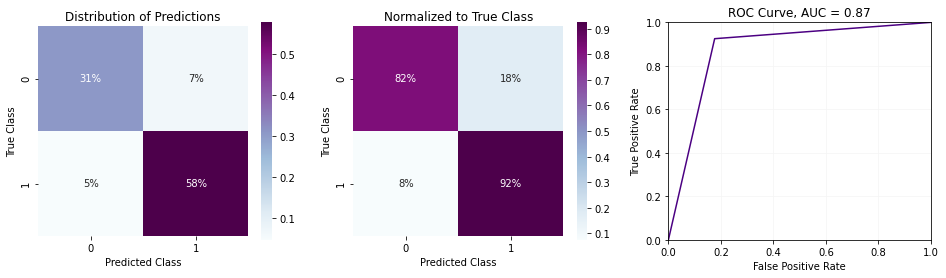

None

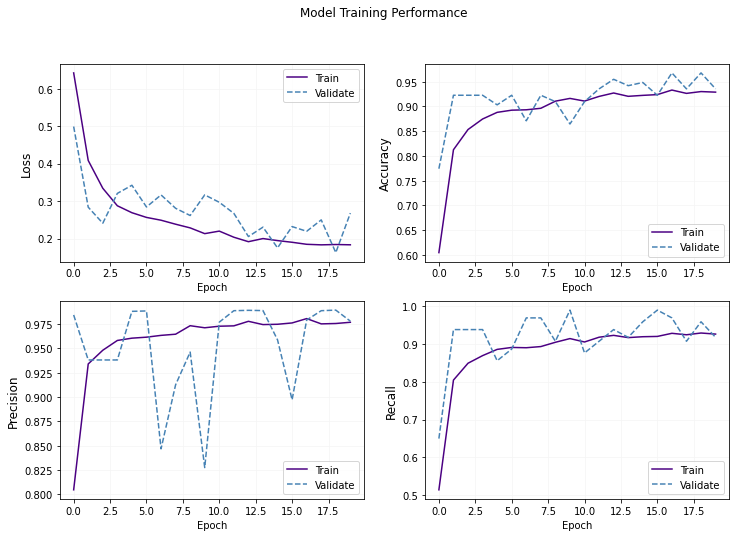

In [ ]:
cnn5_aug = Sequential([Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_image_size),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Dropout(0.2),
                  Conv2D(128, kernel_size=(3, 3), activation='relu'), 
                  Dropout(0.2),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(64, kernel_size=(3, 3), activation='relu'),
                  Dropout(0.2),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(64, kernel_size=(3, 3), activation='relu'),
                  Dropout(0.2),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(32, kernel_size=(3, 3), activation='relu'),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Flatten(),
                  Dense(64, activation='relu'),
                  Dense(1, activation = 'sigmoid')])

cnn5_aug.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

# history5_aug = cnn5_aug.fit(train_data_aug,
                              batch_size = 64,
                              epochs = 20, 
                              validation_data = val_generator,
                              callbacks = checkpoint,
                              class_weight=class_weight)

# display(evaluate_model(cnn5_aug, test_images, test_labels))

------------------------------------------------------------
Classification Report for Test Data: 

              precision    recall  f1-score   support

         0.0       0.97      0.64      0.77       176
         1.0       0.82      0.99      0.90       293

    accuracy                           0.86       469
   macro avg       0.90      0.82      0.84       469
weighted avg       0.88      0.86      0.85       469

------------------------------------------------------------
15/15 [==============================] - 0s 8ms/step - loss: 0.3435 - accuracy: 0.8593 - precision: 0.8215 - recall: 0.9898
Loss of the model is -  0.3434547483921051
15/15 [==============================] - 0s 8ms/step - loss: 0.3435 - accuracy: 0.8593 - precision: 0.8215 - recall: 0.9898
Accuracy of the model is -  85.92750430107117 %
------------------------------------------------------------
Correct: 403, 85.93%
Incorrect: 66, 14.07%
------------------------------------------------------------
Model Pr

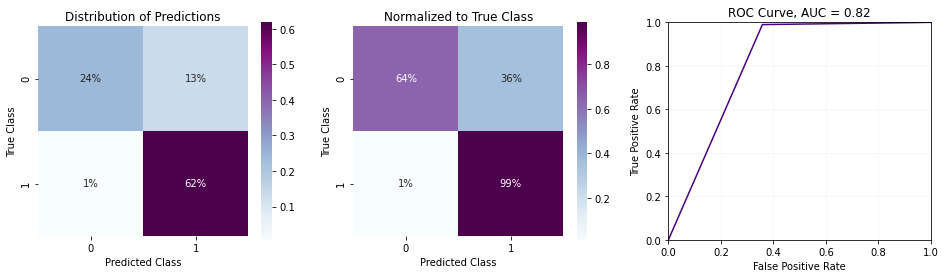

None

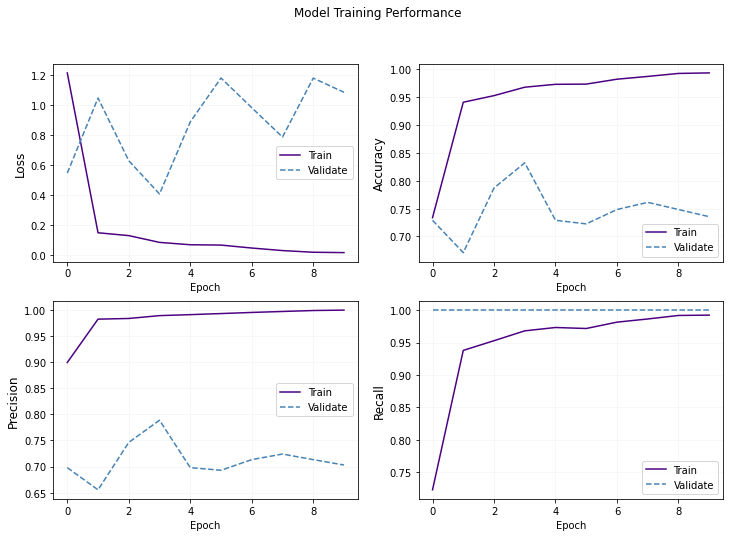

In [43]:
# Load model, history
cnn5_aug = load_model(project_path +'cnn5_aug')
history5_aug_df = pd.read_csv(project_path + 'history2_df.csv')
display(evaluate_model(cnn5_aug, test_images, test_labels))
plot_history_df(history5_aug_df)

# # Evaluate model performance
# display(evaluate_model(cnn5_aug, test_images, test_labels))
# history5_aug_df = plot_metrics(history5_aug_df, df=True)

# To save model and model.history as a DataFrame
# cnn5_aug.save(project_path +'cnn5_aug')
# history5_aug_df.to_csv(project_path+'history5_aug_df.csv', index=False)

Epoch 1/25
82/82 [==============================] - 74s 899ms/step - loss: 0.6404 - accuracy: 0.6321 - precision: 0.8173 - recall: 0.4229 - val_loss: 0.6596 - val_accuracy: 0.8516 - val_precision: 0.9868 - val_recall: 0.7732
Epoch 2/25
82/82 [==============================] - 73s 885ms/step - loss: 0.4908 - accuracy: 0.7613 - precision: 0.9081 - recall: 0.7551 - val_loss: 0.4296 - val_accuracy: 0.8968 - val_precision: 0.9451 - val_recall: 0.8866
Epoch 3/25
82/82 [==============================] - 72s 882ms/step - loss: 0.4196 - accuracy: 0.8004 - precision: 0.9339 - recall: 0.7871 - val_loss: 0.3242 - val_accuracy: 0.9097 - val_precision: 0.8879 - val_recall: 0.9794
Epoch 4/25
82/82 [==============================] - 72s 883ms/step - loss: 0.3584 - accuracy: 0.8399 - precision: 0.9450 - recall: 0.8330 - val_loss: 0.3596 - val_accuracy: 0.8968 - val_precision: 0.8785 - val_recall: 0.9691
Epoch 5/25
82/82 [==============================] - 73s 886ms/step - loss: 0.3567 - accuracy: 0.8428

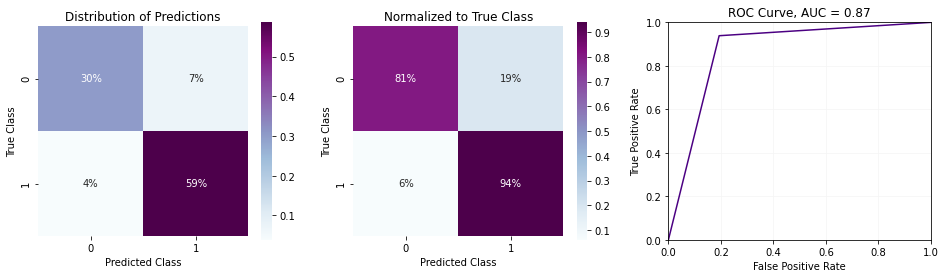

None

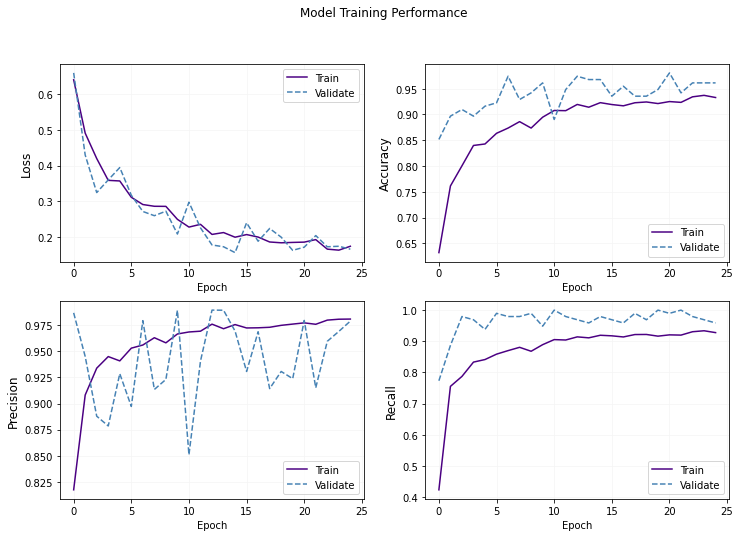

In [ ]:
cnn3_do_aug_2 = Sequential([Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_image_size),
                  Dropout(0.2),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(64, kernel_size=(3, 3), activation='relu'),
                  Dropout(0.2),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(32, kernel_size=(3, 3), activation='relu'),
                  Dropout(0.2),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Flatten(),
                  Dense(32, activation='relu'),
                  Dense(1, activation = 'sigmoid')])

cnn3_do_aug_2.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)

history3_do_aug_2 = cnn3_do_aug_2.fit(train_data_aug_2,
                              batch_size = 64,
                              epochs = 25, 
                              validation_data = val_generator,
                              callbacks = checkpoint,
                              class_weight=class_weight)

display(evaluate_model(cnn3_do_aug, test_images, test_labels))
plot_metrics(history3_do_aug_2)

------------------------------------------------------------
Classification Report for Test Data: 

              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85       176
         1.0       0.88      0.96      0.92       293

    accuracy                           0.90       469
   macro avg       0.90      0.87      0.88       469
weighted avg       0.90      0.90      0.89       469

------------------------------------------------------------
15/15 [==============================] - 0s 8ms/step - loss: 0.2806 - accuracy: 0.8955 - precision: 0.8836 - recall: 0.9590
Loss of the model is -  0.28061023354530334
15/15 [==============================] - 0s 7ms/step - loss: 0.2806 - accuracy: 0.8955 - precision: 0.8836 - recall: 0.9590
Accuracy of the model is -  89.552241563797 %
------------------------------------------------------------
Correct: 420, 89.55%
Incorrect: 49, 10.45%
------------------------------------------------------------
Model Pre

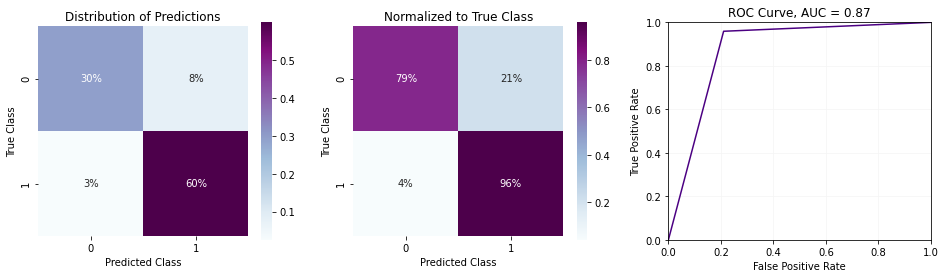

None

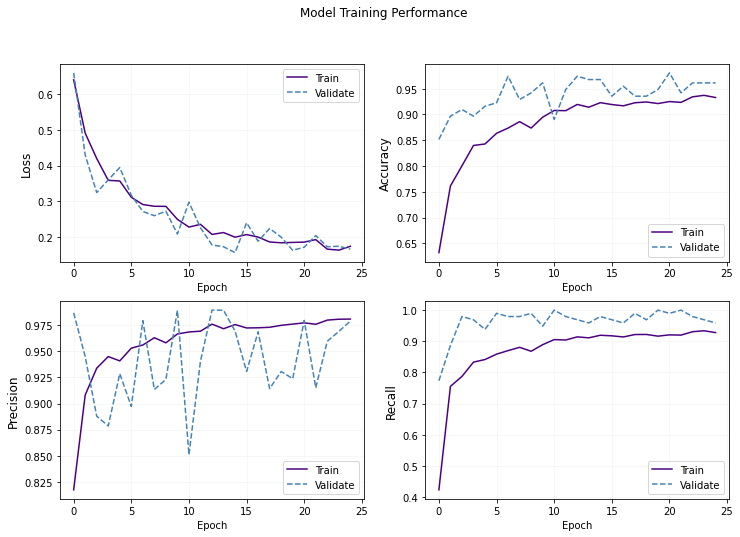

In [44]:
# Load model, history
cnn3_do_aug_2 = load_model(project_path +'cnn3_do_aug_2')
history3_do_aug_2_df = pd.read_csv(project_path + 'history3_do_aug_2_df.csv')
display(evaluate_model(cnn3_do_aug_2, test_images, test_labels))
plot_history_df(history3_do_aug_2_df)

# # Evaluate model performance
# display(evaluate_model(cnn3_do_aug_2, test_images, test_labels))
# history3_do_aug_2_df = plot_metrics(history3_do_aug_2, df=True)

# # To save model and model.history as a DataFrame
# cnn3_do_aug_2.save(project_path +'cnn3_do_aug_2')
# history3_do_aug_2_df.to_csv(project_path+'history3_do_aug_2_df.csv', index=False)

#### Best model


##### Save / Load as Json


In [ ]:
# # save weights!
# # serialize model to JSON
# model_json = cnn4_do_aug.to_json()
# with open(project_path+"cnn4_do_aug.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# cnn4_do_aug.save_weights(project_path+"cnn4_do_aug_30W_2.h5")
# print("Saved model to disk")

Saved model to disk


In [45]:
# Load json and create model
json_file = open(project_path+'cnn4_do_aug.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
cnn4_do_aug_dp = model_from_json(loaded_model_json)
# Load weights into new model
cnn4_do_aug_dp.load_weights(project_path+"cnn4_do_aug_30W_2.h5")
print("Loaded model from disk")

Loaded model from disk


------------------------------------------------------------
Classification Report for Test Data: 

              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86       176
         1.0       0.90      0.94      0.92       293

    accuracy                           0.90       469
   macro avg       0.90      0.88      0.89       469
weighted avg       0.90      0.90      0.90       469

------------------------------------------------------------
15/15 [==============================] - 0s 8ms/step - loss: 0.2689 - accuracy: 0.8977 - precision: 0.8990 - recall: 0.9420
Loss of the model is -  0.2689375579357147
15/15 [==============================] - 0s 7ms/step - loss: 0.2689 - accuracy: 0.8977 - precision: 0.8990 - recall: 0.9420
Accuracy of the model is -  89.76545929908752 %
------------------------------------------------------------
Correct: 421, 89.77%
Incorrect: 48, 10.23%
------------------------------------------------------------
Model Pr

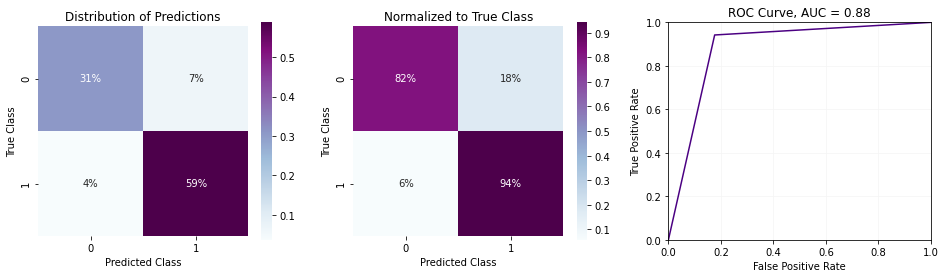

In [46]:
# Check load
cnn4_do_aug_dp.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)
evaluate_model(cnn4_do_aug_dp, test_images, test_labels)

Unfortunately the training history for this model is lost, as I didn't know I had to save the history as a seperate variable. I do know that it was run with batch size 64 for for 25 epochs and then batch size 32 for 5 more epochs (total 32).

# Evaluation


#### Final Model Arcitecture


In [47]:
fin_model = cnn4_do_aug_dp
fin_model.summary() 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 128, 128)     0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 62, 62, 64)        73792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 29, 29, 32)       

In [48]:
# Count convolution/pooling layers in model summary (everything before 'flat')
# for use in visualizing layers 
n = 9

# Number of channels in first convolutional layer
c0 = 128

# Number of channels in final convolutional layer (before flatten)
c1 = 32

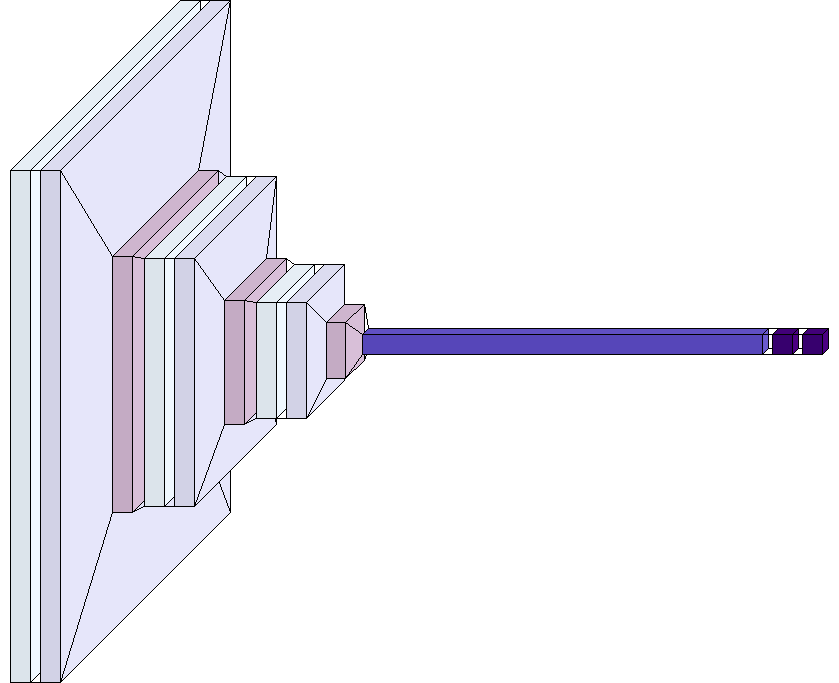

In [49]:
# Visualize arcitecture of final model, save to project file
visualkeras.layered_view(fin_model, color_map = color_map, to_file = project_path+'visualkeras_3D.png')

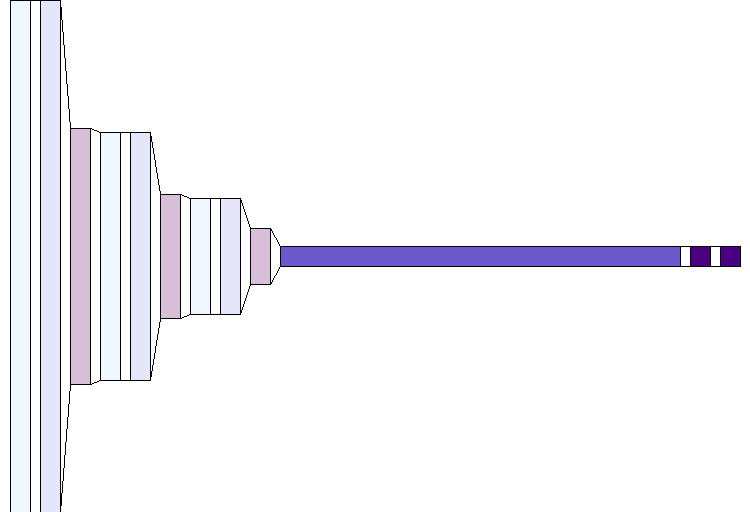

In [50]:
# Flatttened visual, save to project file
visualkeras.layered_view(fin_model, draw_volume=False, color_map=color_map, to_file = project_path+'visualkeras_2D.png')

### Preprocess evalution images

Preprocess evalution images from untouched downloaded validation set of 16 image. Blind to all previous programming.

In [51]:
# Preprocessing validation images the same as the model to use to predict
val_datagen = ImageDataGenerator(rescale=(1./255))
val_data = val_datagen.flow_from_directory(val_path, 
                                            target_size=target_img_size,
                                            batch_size=get_num_images(val_path),
                                            class_mode='binary')

# Get the images and labels as np.arrays                                          
val_imgs, val_labels = next(val_data)
val_key = val_data.class_indices
val_key

Found 16 images belonging to 2 classes.


{'NORMAL': 0, 'PNEUMONIA': 1}

In [52]:
# Flip dict to be able to search by predicted class as key
pred_key = {value:key for key, value in val_key.items()}
pred_key

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [65]:
# Select a random training image and label to evalute
i = np.random.choice(range(len(val_labels)))
label = val_labels[i]
img = val_imgs[i]

# Format as 4D tensor for feature mapping
img_tensor = np.expand_dims(val_imgs[i], axis=0)
img_tensor.shape

(1, 128, 128, 3)

### Visualize intermediate layers

In [69]:
# Extract model layer outputs, using 'n' number of convolutional layers
layer_outputs = [layer.output for layer in fin_model.layers[:n]]
layer_outputs
# Make a model to display the feature maps
activation_model = models.Model(inputs=fin_model.input, outputs=layer_outputs)

# Get feature maps for the layers
activations = activation_model.predict(img_tensor)

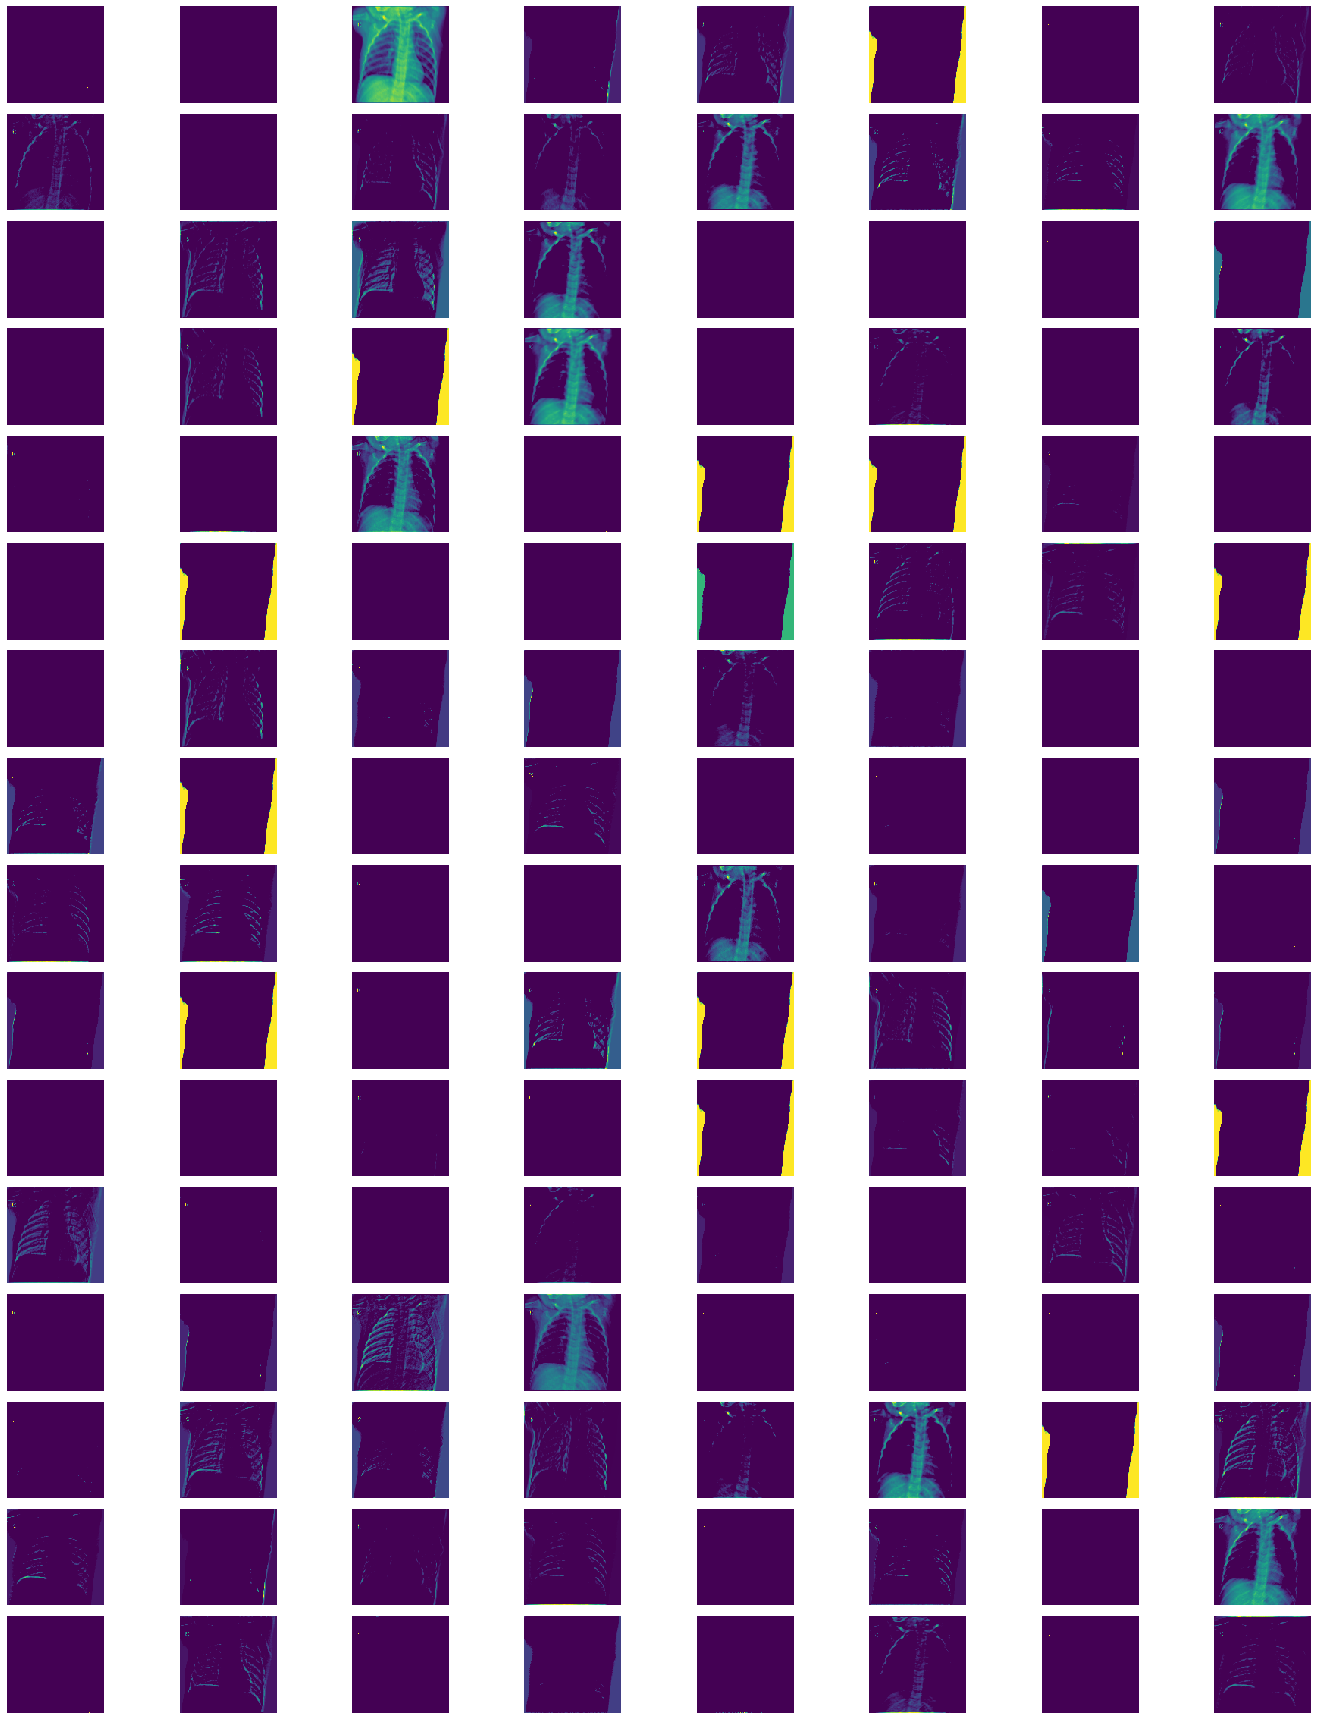

In [80]:
# Visualize all channels from first activation layer
fig, axes = plt.subplots(16, 8, figsize=(20,24))
for i in range(c0):
    row = i//8
    column = i%8
    ax = axes[row, column]
    ax.axis("off")
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')
fig.tight_layout()

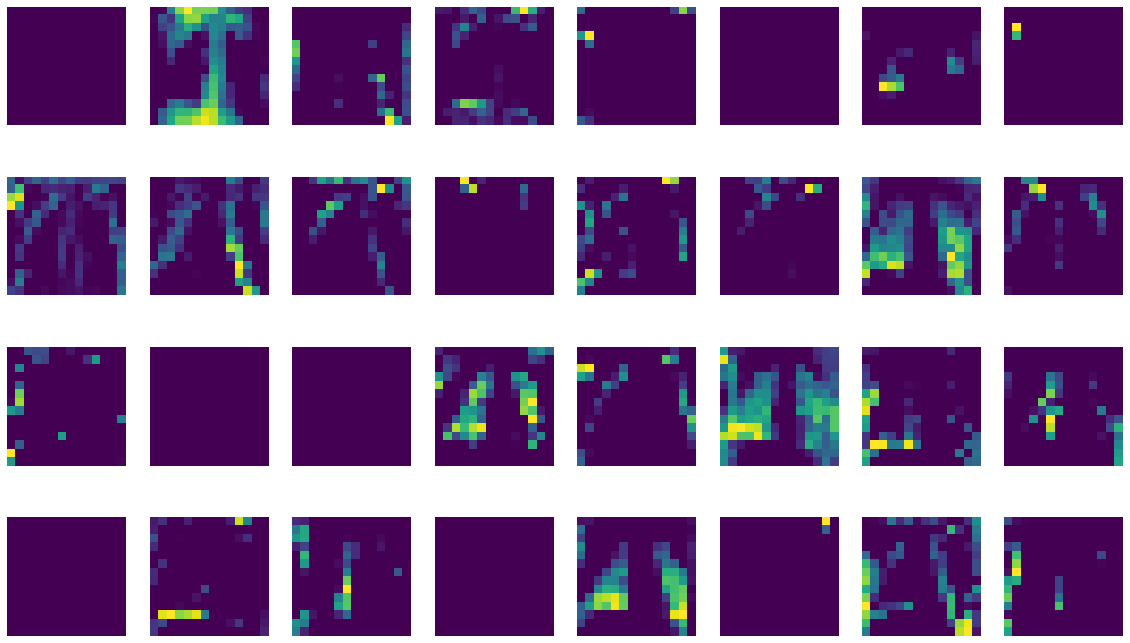

In [81]:
# Visualize all channels from last convolutional activation layer
fig, axes = plt.subplots(4, 8, figsize=(20,12))
for i in range(c1):
    row = i//8
    column = i%8
    ax = axes[row, column]
    ax.axis("off")
    first_layer_activation = activations[n-1]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

### Image explanation with LIME

val image 4
Prediction: NORMAL
Actual: NORMAL


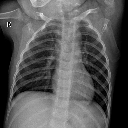

Correct!


In [66]:
# Predict label and preview image
pred = int(fin_model.predict(np.array([img])).round())
print(f"val image {i}")
print("Prediction:", pred_key.get(pred))
print("Actual:", pred_key.get(label))
display(array_to_img(img))
print("Correct!") if pred_key.get(label) == pred_key.get(pred) else print("Incorrect!")

In [72]:
# Make an explainer of image patterns identified (HOW is model working?)
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(img, fin_model.predict, top_labels=2,
                                         hide_color=None, num_samples=2000)

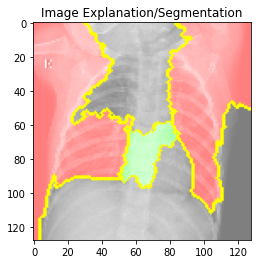

In [78]:
# Select the same class explained by the image
class_exp =  explanation.top_labels[0]

# View the explainer over the image
temp, mask = explanation.get_image_and_mask(class_exp, 
                                            positive_only=False,
                                            num_features=5)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask));
plt.title("Image Explanation/Segmentation")
plt.show()

Green shows what posittively contributed towards class prediction and red shows what negatively contributed (or contributed towards non-predicted class). Essentially green is the greatest 'pro' superpixel and red is the greatest'con' superpixel towards the finalized prediction. The larger superpixel indicates the predicted class (red: 0, normal; or green: 1, pneumonia).

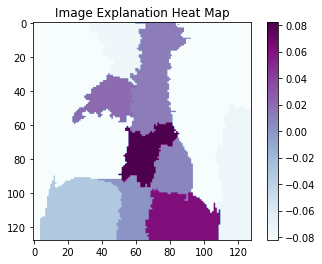

In [74]:
#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[class_exp])
exp_map = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot, colorbar indications superpixel weights
plt.imshow(exp_map, cmap = 'BuPu', vmin  = -exp_map.max(), vmax = exp_map.max());
plt.colorbar()
plt.title("Image Explanation Heat Map")
plt.show()

This heatmap shows the segments learned by the model. The darker colors are the high positive (class 1, pneumonia) weights and the lighter colors indicate the negative class (0, normal). The red/green overlay on the x-ray show weights greater than (absolute) 0.1.

# Conclusions

Final Model Metrics


*   Accuracy - 89.77%
*   Recall - 94 %
*   Precision - 82 %
*   AUC - 0.88







Reccomendations
- Continue collecting labeled images to progressively train the model.
- Store image data at 128 x 128 to conserve storage memory (this is up to a 10% reduction in original image size).
- Use the model to improve efficiency of Xray review.

Future Work
- This is a supervised learning task and thus performance is based on the quality of the dataset used. Collect more labeled images or continue data augmentation to increase the quantity of images in the training set.
- Try transfer learning - use an established x-ray classifier and build model on top of that.
- Progressively resize the model input image size to find the smallest possible input size without sacrificing performance.
